In [4]:
!pip install ogb

In [5]:
from torch_scatter import scatter_softmax, scatter_mean

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Embedding, ModuleList
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU
from torch_scatter import scatter, scatter_mean, scatter_add, scatter_sum
from torch_geometric.nn import GINConv, GINEConv


class AtomEncoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(AtomEncoder, self).__init__()

        self.embeddings = torch.nn.ModuleList()

        for i in range(9):
            self.embeddings.append(Embedding(100, hidden_channels))

    def reset_parameters(self):
        for embedding in self.embeddings:
            embedding.reset_parameters()

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(1)

        out = 0
        for i in range(x.size(1)):
            out += self.embeddings[i](x[:, i])
        return out


class BondEncoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(BondEncoder, self).__init__()

        self.embeddings = torch.nn.ModuleList()

        for i in range(3):
            self.embeddings.append(Embedding(6, hidden_channels))

    def reset_parameters(self):
        for embedding in self.embeddings:
            embedding.reset_parameters()

    def forward(self, edge_attr):
        if edge_attr.dim() == 1:
            edge_attr = edge_attr.unsqueeze(1)

        out = 0
        for i in range(edge_attr.size(1)):
            out += self.embeddings[i](edge_attr[:, i])
        return out


class Global_Gen_Sum_Mean_Max_Pool(nn.Module):
    def __init__(self, family = "softmax", p = 1.0, beta = 1.0, 
                 trainable_p = False, trainable_beta = False):
        r"""Performs batch-wise graph-level-outputs by transforming node
        features based on a Generalized Aggr-Mean-Max function, so that
        for a single graph :math:`\mathcal{G}_i` its output is computed
        deppending on the family of transformations by:
        .. math::
            \mathbf{r}_i = \frac{1}{\beta*N_i} \sum_{n=1}^{N_i} \mathbf{softmax} \left( \mathbf{x}_n * p \right) * \mathbf{x}_n
        for softmax aggregation or
        .. math::
            \mathbf{r}_i = \left( \frac{1}{\beta*N_i} \sum_{n=1}^{N_i} \mathbf{x}_n^{p} \right)^{1/p}
        for power mean aggregation.

        Args:
            family (str): family of generalized mean-max functions to use. 
                Either "softmax" or "power" for eq. 1 or eq. 2 respectively.
            p (float): parameter for the generalized mean-max function
            trainable (bool): whether the value of p is learnable during training.
        """
        super(Global_Gen_Sum_Mean_Max_Pool, self).__init__()
        
        self.family         = family
        self.base_p         = p
        self.base_beta      = beta
        self.trainable_p    = trainable_p
        self.trainable_beta = trainable_beta
        # define params
        self.p = torch.nn.Parameter(torch.tensor([p], device=device),
                                    requires_grad=trainable_p)# .to(device)
        self.beta = torch.nn.Parameter(torch.tensor([beta], device=device),
                                       requires_grad=trainable_beta)# .to(device)

    def forward(self, x, batch, bsize=None):
        r"""Args:
            x (Tensor): Node feature matrix
                :math:`\mathbf{X} \in \mathbb{R}^{(N_1 + \ldots + N_B) \times F}`.
            batch (LongTensor): Batch vector :math:`\mathbf{b} \in {\{ 0, \ldots,
                B-1\}}^N`, which assigns each node to a specific example.
            size (int, optional): Batch-size :math:`B`.
                Automatically calculated if not given. (default: :obj:`None`)
        :rtype: :class:`Tensor`
        """
        bsize = int(batch.max().item() + 1) if bsize is None else bsize
        n_nodes = scatter_sum(torch.ones_like(x), batch, dim=0, dim_size=bsize)
        if self.family == "softmax":
            out = scatter_softmax(self.p * x.detach(), batch, dim=0)
            return scatter_add(x * out,
                                batch, dim=0, dim_size=bsize)*n_nodes / (1+self.beta*(n_nodes-1))

        elif self.family == "power":
            # numerical stability - avoid powers of large numbers or negative ones
            min_x, max_x = 1e-7, 1e+3
            torch.clamp_(x, min_x, max_x)
            out = scatter_add(torch.pow(x, self.p),
                               batch, dim=0, dim_size=bsize) / (1+self.beta*(n_nodes-1))
            torch.clamp_(out, min_x, max_x)
            return torch.pow(out, 1 / self.p)


    def reset_parameters(self):
        if self.p and torch.is_tensor(self.p):
            self.p.data.fill_(self.base_p)
        if self.beta and torch.is_tensor(self.beta):
            self.beta.data.fill_(self.base_beta)


    def __repr__(self):
        return "Generalized Aggr-Mean-Max global pooling layer with params:" + \
               str({"family": self.family,
                    "base_p": self.base_p,
                    "base_beta"     : self.base_beta,
                    "trainable_p"   : self.trainable_p,
                    "trainable_beta": self.trainable_beta})



class Net(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers, dropout=0.0,
                 inter_message_passing=True):
        super(Net, self).__init__()
        self.num_layers = num_layers
        self.dropout = dropout
        self.inter_message_passing = inter_message_passing

        self.atom_encoder = AtomEncoder(hidden_channels)
        self.clique_encoder = Embedding(4, hidden_channels)

        self.bond_encoders = ModuleList()
        self.atom_convs = ModuleList()
        self.atom_batch_norms = ModuleList()
        self.reader = Global_Gen_Sum_Mean_Max_Pool(family = "power", p = 10.0, beta = 1e-5, 
                                                   trainable_p = True, trainable_beta = True)

        for _ in range(num_layers):
            self.bond_encoders.append(BondEncoder(hidden_channels))
            nn = Sequential(
                Linear(hidden_channels, 2 * hidden_channels),
                BatchNorm1d(2 * hidden_channels),
                ReLU(),
                Linear(2 * hidden_channels, hidden_channels),
            )
            self.atom_convs.append(GINEConv(nn, train_eps=True))
            self.atom_batch_norms.append(BatchNorm1d(hidden_channels))

        self.clique_convs = ModuleList()
        self.clique_batch_norms = ModuleList()

        for _ in range(num_layers):
            nn = Sequential(
                Linear(hidden_channels, 2 * hidden_channels),
                BatchNorm1d(2 * hidden_channels),
                ReLU(),
                Linear(2 * hidden_channels, hidden_channels),
            )
            self.clique_convs.append(GINConv(nn, train_eps=True))
            self.clique_batch_norms.append(BatchNorm1d(hidden_channels))

        self.atom2clique_lins = ModuleList()
        self.clique2atom_lins = ModuleList()

        for _ in range(num_layers):
            self.atom2clique_lins.append(
                Linear(hidden_channels, hidden_channels))
            self.clique2atom_lins.append(
                Linear(hidden_channels, hidden_channels))

        self.atom_lin = Linear(hidden_channels, hidden_channels)
        self.clique_lin = Linear(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def reset_parameters(self):
        self.atom_encoder.reset_parameters()
        self.clique_encoder.reset_parameters()

        for emb, conv, batch_norm in zip(self.bond_encoders, self.atom_convs,
                                         self.atom_batch_norms):
            emb.reset_parameters()
            conv.reset_parameters()
            batch_norm.reset_parameters()

        for conv, batch_norm in zip(self.clique_convs,
                                    self.clique_batch_norms):
            conv.reset_parameters()
            batch_norm.reset_parameters()

        for lin1, lin2 in zip(self.atom2clique_lins, self.clique2atom_lins):
            lin1.reset_parameters()
            lin2.reset_parameters()

        self.atom_lin.reset_parameters()
        self.clique_lin.reset_parameters()
        self.lin.reset_parameters()
        self.reader.reset_parameters()

    def forward(self, data):
        x = self.atom_encoder(data.x.squeeze())

        if self.inter_message_passing:
            x_clique = self.clique_encoder(data.x_clique.squeeze())

        for i in range(self.num_layers):
            edge_attr = self.bond_encoders[i](data.edge_attr)
            x = self.atom_convs[i](x, data.edge_index, edge_attr)
            x = self.atom_batch_norms[i](x)
            x = F.relu(x)
            x = F.dropout(x, self.dropout, training=self.training)

            if self.inter_message_passing:
                row, col = data.atom2clique_index

                x_clique = x_clique + F.relu(self.atom2clique_lins[i](scatter(
                    x[row], col, dim=0, dim_size=x_clique.size(0),
                    reduce='mean')))

                x_clique = self.clique_convs[i](x_clique, data.tree_edge_index)
                x_clique = self.clique_batch_norms[i](x_clique)
                x_clique = F.relu(x_clique)
                x_clique = F.dropout(x_clique, self.dropout,
                                     training=self.training)

                x = x + F.relu(self.clique2atom_lins[i](scatter(
                    x_clique[col], row, dim=0, dim_size=x.size(0),
                    reduce='mean')))

        x = self.reader(x, data.batch)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.atom_lin(x)

        if self.inter_message_passing:
            tree_batch = torch.repeat_interleave(data.num_cliques)
            x_clique = scatter(x_clique, tree_batch, dim=0, dim_size=x.size(0),
                               reduce='mean')
            x_clique = F.dropout(x_clique, self.dropout,
                                 training=self.training)
            x_clique = self.clique_lin(x_clique)
            x = x + x_clique

        x = F.relu(x)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.lin(x)
        return x

In [7]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import tree_decomposition

from rdkit import Chem
from rdkit.Chem.rdchem import BondType

bonds = [BondType.SINGLE, BondType.DOUBLE, BondType.TRIPLE, BondType.AROMATIC]


def mol_from_data(data):
    mol = Chem.RWMol()

    x = data.x if data.x.dim() == 1 else data.x[:, 0]
    for z in x.tolist():
        mol.AddAtom(Chem.Atom(z))

    row, col = data.edge_index
    mask = row < col
    row, col = row[mask].tolist(), col[mask].tolist()

    bond_type = data.edge_attr
    bond_type = bond_type if bond_type.dim() == 1 else bond_type[:, 0]
    bond_type = bond_type[mask].tolist()

    for i, j, bond in zip(row, col, bond_type):
        assert bond >= 1 and bond <= 4
        mol.AddBond(i, j, bonds[bond - 1])

    return mol.GetMol()


class JunctionTreeData(Data):
    def __inc__(self, key, item):
        if key == 'tree_edge_index':
            return self.x_clique.size(0)
        elif key == 'atom2clique_index':
            return torch.tensor([[self.x.size(0)], [self.x_clique.size(0)]])
        else:
            return super(JunctionTreeData, self).__inc__(key, item)


class JunctionTree(object):
    def __call__(self, data):
        mol = mol_from_data(data)
        out = tree_decomposition(mol, return_vocab=True)
        tree_edge_index, atom2clique_index, num_cliques, x_clique = out

        data = JunctionTreeData(**{k: v for k, v in data})

        data.tree_edge_index = tree_edge_index
        data.atom2clique_index = atom2clique_index
        data.num_cliques = num_cliques
        data.x_clique = x_clique

        return data

In [8]:
# edit the function causing the error: add argument chem=None + modify function code: 
# Chem=chem if chem is not None else Chem

# tree_decomposition(Chem.MolFromSmiles("cicccc1c"), return_vocab=True)
# once modified and saved, restart the environmnet, comment this cell and run the experiment.

In [9]:
import argparse

import torch
from torch.optim import Adam
import numpy as np
from sklearn.metrics import roc_auc_score

from ogb.graphproppred import PygGraphPropPredDataset
from torch_geometric.data import DataLoader
from torch_geometric.transforms import Compose

class Argparse_emulate():
    def __init__(self, device=0, hidden_channels=256, num_layers=2, dropout=0.5,
               epochs=100, no_inter_message_passing="store_true"):
        self.device = device
        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.dropout = dropout
        self.epochs = epochs
        self.no_inter_message_passing = no_inter_message_passing
        return

args = Argparse_emulate()
# parser.add_argument('--device', type=int, default=0)
# parser.add_argument('--hidden_channels', type=int, default=256)
# parser.add_argument('--num_layers', type=int, default=2)
# parser.add_argument('--dropout', type=float, default=0.5)
# parser.add_argument('--epochs', type=int, default=100)
# parser.add_argument('--no_inter_message_passing', action='store_true')
# args = parser.parse_args()
# print(args)


class OGBTransform(object):
    # OGB saves atom and bond types zero-index based. We need to revert that.
    def __call__(self, data):
        data.x[:, 0] += 1
        data.edge_attr[:, 0] += 1
        return data


transform = Compose([OGBTransform(), JunctionTree()])

name = 'ogbg-molhiv'
dataset = PygGraphPropPredDataset(name, 'data', pre_transform=transform)

dataset = dataset.shuffle()
num_train, num_trainval = round(0.8 * len(dataset)), round(0.9 * len(dataset))
train_dataset = dataset[:num_train]
val_dataset = dataset[num_train:num_trainval]
test_dataset = dataset[num_trainval:]

train_loader = DataLoader(train_dataset, 128, shuffle=True)
val_loader = DataLoader(val_dataset, 128, shuffle=False)
test_loader = DataLoader(test_dataset, 128, shuffle=False)


device = f'cuda:{args.device}' if torch.cuda.is_available() else 'cpu'

Using backend: pytorch


In [10]:
def train(epoch, vals=False):
    values = []
    model.train()

    total_loss = 0
    for i,data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        mask = ~torch.isnan(data.y)
        out = model(data)[mask]
        y = data.y.to(torch.float)[mask]
        loss = torch.nn.BCEWithLogitsLoss()(out, y)
        loss.backward()
        total_loss += loss.item() * data.num_graphs
        optimizer.step()
        # record beta and p values
        if vals:
            # display computational graph
            # global g
            #g = make_dot(out)
            # "a"+9
            values_batch = {}
            values_batch["p"]    = model.reader.p.detach().cpu().numpy()
            values_batch["beta"] = model.reader.beta.detach().cpu().numpy()
            values.append(values_batch)
            if False: # i==0:
                print("records:", i, "value:", values_batch)


    return total_loss / len(train_loader.dataset), values


@torch.no_grad()
def test(loader):
    model.eval()

    y_preds, y_trues = [], []
    for data in loader:
        data = data.to(device)
        y_preds.append(model(data))
        y_trues.append(data.y)

    y_pred = torch.cat(y_preds, dim=0).cpu().numpy()
    y_true = torch.cat(y_trues, dim=0).cpu().numpy()

    rocauc_list = []
    for i in range(y_true.shape[1]):
        # AUC is only defined when there is at least one positive data.
        if np.sum(y_true[:, i] == 1) > 0 and np.sum(y_true[:, i] == 0) > 0:
            # ignore nan values
            is_labeled = y_true[:, i] == y_true[:, i]
            rocauc_list.append(
                roc_auc_score(y_true[is_labeled, i], y_pred[is_labeled, i]))

    return {"rocauc": sum(rocauc_list) / len(rocauc_list)}


values     = []
test_perfs = []
for run in range(10):
    print()
    print(f'Run {run}:')
    print()
    model = Net(hidden_channels=args.hidden_channels,
            out_channels=dataset.num_tasks, num_layers=args.num_layers,
            dropout = args.dropout if run<10 else 0.6, # edited to increase dropout
            inter_message_passing=not args.no_inter_message_passing).to(device)

    model.reset_parameters()
    optimizer = Adam(model.parameters(), lr=0.0001)

    best_val_perf = test_perf = 0
    for epoch in range(1, args.epochs + 1):
        loss, epoch_values = train(epoch, vals=True)
        train_perf = test(train_loader)
        val_perf = test(val_loader)

        if val_perf["rocauc"] > best_val_perf:
            best_val_perf = val_perf["rocauc"]
            test_perf = test(test_loader)

        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
              f'Train: {train_perf["rocauc"]:.4f}, Val: {val_perf["rocauc"]:.4f}, '
              f'Test: {test_perf["rocauc"]:.4f}')
        if epoch % 10 == 0:
            print("Recorded values:", epoch_values)

    test_perfs.append(test_perf["rocauc"])
    values.append(epoch_values[-1])

test_perf = torch.tensor(test_perfs)
print('===========================')
print(f'Final Test: {test_perf.mean():.4f} ± {test_perf.std():.4f}')


Run 0:

Epoch: 001, Loss: 0.1699, Train: 0.5648, Val: 0.5442, Test: 0.5600
Epoch: 002, Loss: 0.1583, Train: 0.6290, Val: 0.6085, Test: 0.6235
Epoch: 003, Loss: 0.1559, Train: 0.6866, Val: 0.6682, Test: 0.6763
Epoch: 004, Loss: 0.1516, Train: 0.7067, Val: 0.6799, Test: 0.6994
Epoch: 005, Loss: 0.1488, Train: 0.7088, Val: 0.6841, Test: 0.7018
Epoch: 006, Loss: 0.1450, Train: 0.7285, Val: 0.7043, Test: 0.7254
Epoch: 007, Loss: 0.1445, Train: 0.7396, Val: 0.7226, Test: 0.7308
Epoch: 008, Loss: 0.1419, Train: 0.7378, Val: 0.7202, Test: 0.7308
Epoch: 009, Loss: 0.1393, Train: 0.7549, Val: 0.7363, Test: 0.7411
Epoch: 010, Loss: 0.1379, Train: 0.7587, Val: 0.7455, Test: 0.7455
Recorded values: [{'p': array([10.002762], dtype=float32), 'beta': array([0.05034911], dtype=float32)}, {'p': array([10.002705], dtype=float32), 'beta': array([0.05033003], dtype=float32)}, {'p': array([10.002657], dtype=float32), 'beta': array([0.05031571], dtype=float32)}, {'p': array([10.00262], dtype=float32), 'beta

Epoch: 011, Loss: 0.1367, Train: 0.7635, Val: 0.7518, Test: 0.7442
Epoch: 012, Loss: 0.1342, Train: 0.7683, Val: 0.7433, Test: 0.7442
Epoch: 013, Loss: 0.1329, Train: 0.7725, Val: 0.7592, Test: 0.7434
Epoch: 014, Loss: 0.1316, Train: 0.7770, Val: 0.7525, Test: 0.7434
Epoch: 015, Loss: 0.1294, Train: 0.7772, Val: 0.7472, Test: 0.7434
Epoch: 016, Loss: 0.1299, Train: 0.7830, Val: 0.7531, Test: 0.7434
Epoch: 017, Loss: 0.1279, Train: 0.7904, Val: 0.7697, Test: 0.7620
Epoch: 018, Loss: 0.1263, Train: 0.7951, Val: 0.7605, Test: 0.7620
Epoch: 019, Loss: 0.1291, Train: 0.7973, Val: 0.7688, Test: 0.7620
Epoch: 020, Loss: 0.1245, Train: 0.8048, Val: 0.7719, Test: 0.7772
Recorded values: [{'p': array([9.983256], dtype=float32), 'beta': array([0.08489957], dtype=float32)}, {'p': array([9.983248], dtype=float32), 'beta': array([0.08489487], dtype=float32)}, {'p': array([9.983236], dtype=float32), 'beta': array([0.08490412], dtype=float32)}, {'p': array([9.983228], dtype=float32), 'beta': array([0.

Epoch: 021, Loss: 0.1235, Train: 0.8143, Val: 0.7859, Test: 0.7862
Epoch: 022, Loss: 0.1225, Train: 0.8011, Val: 0.7739, Test: 0.7862
Epoch: 023, Loss: 0.1222, Train: 0.8167, Val: 0.7721, Test: 0.7862
Epoch: 024, Loss: 0.1214, Train: 0.8188, Val: 0.7792, Test: 0.7862
Epoch: 025, Loss: 0.1204, Train: 0.8282, Val: 0.7812, Test: 0.7862
Epoch: 026, Loss: 0.1206, Train: 0.8125, Val: 0.7766, Test: 0.7862
Epoch: 027, Loss: 0.1191, Train: 0.8172, Val: 0.7821, Test: 0.7862
Epoch: 028, Loss: 0.1183, Train: 0.8250, Val: 0.7878, Test: 0.7823
Epoch: 029, Loss: 0.1163, Train: 0.8261, Val: 0.7795, Test: 0.7823
Epoch: 030, Loss: 0.1165, Train: 0.8219, Val: 0.7864, Test: 0.7823
Recorded values: [{'p': array([9.9607315], dtype=float32), 'beta': array([0.11269581], dtype=float32)}, {'p': array([9.960696], dtype=float32), 'beta': array([0.11270016], dtype=float32)}, {'p': array([9.960672], dtype=float32), 'beta': array([0.11269961], dtype=float32)}, {'p': array([9.960641], dtype=float32), 'beta': array([0

Epoch: 031, Loss: 0.1158, Train: 0.8346, Val: 0.7744, Test: 0.7823
Epoch: 032, Loss: 0.1147, Train: 0.8390, Val: 0.7851, Test: 0.7823
Epoch: 033, Loss: 0.1157, Train: 0.8320, Val: 0.7976, Test: 0.7946
Epoch: 034, Loss: 0.1149, Train: 0.8365, Val: 0.7724, Test: 0.7946
Epoch: 035, Loss: 0.1149, Train: 0.8376, Val: 0.7881, Test: 0.7946
Epoch: 036, Loss: 0.1135, Train: 0.8337, Val: 0.7838, Test: 0.7946
Epoch: 037, Loss: 0.1138, Train: 0.8465, Val: 0.7975, Test: 0.7946
Epoch: 038, Loss: 0.1129, Train: 0.8381, Val: 0.7858, Test: 0.7946
Epoch: 039, Loss: 0.1128, Train: 0.8502, Val: 0.7885, Test: 0.7946
Epoch: 040, Loss: 0.1134, Train: 0.8414, Val: 0.7764, Test: 0.7946
Recorded values: [{'p': array([9.940172], dtype=float32), 'beta': array([0.13508911], dtype=float32)}, {'p': array([9.940266], dtype=float32), 'beta': array([0.13523352], dtype=float32)}, {'p': array([9.940354], dtype=float32), 'beta': array([0.13536775], dtype=float32)}, {'p': array([9.940428], dtype=float32), 'beta': array([0.

Epoch: 041, Loss: 0.1112, Train: 0.8496, Val: 0.7836, Test: 0.7946
Epoch: 042, Loss: 0.1147, Train: 0.8408, Val: 0.7836, Test: 0.7946
Epoch: 043, Loss: 0.1107, Train: 0.8454, Val: 0.7918, Test: 0.7946
Epoch: 044, Loss: 0.1119, Train: 0.8535, Val: 0.7887, Test: 0.7946
Epoch: 045, Loss: 0.1107, Train: 0.8563, Val: 0.7859, Test: 0.7946
Epoch: 046, Loss: 0.1095, Train: 0.8485, Val: 0.7832, Test: 0.7946
Epoch: 047, Loss: 0.1084, Train: 0.8546, Val: 0.7873, Test: 0.7946
Epoch: 048, Loss: 0.1104, Train: 0.8502, Val: 0.7790, Test: 0.7946
Epoch: 049, Loss: 0.1086, Train: 0.8540, Val: 0.7879, Test: 0.7946
Epoch: 050, Loss: 0.1078, Train: 0.8673, Val: 0.7961, Test: 0.7946
Recorded values: [{'p': array([9.920759], dtype=float32), 'beta': array([0.15238465], dtype=float32)}, {'p': array([9.920727], dtype=float32), 'beta': array([0.15238246], dtype=float32)}, {'p': array([9.920685], dtype=float32), 'beta': array([0.15238038], dtype=float32)}, {'p': array([9.92064], dtype=float32), 'beta': array([0.1

Epoch: 051, Loss: 0.1067, Train: 0.8638, Val: 0.7906, Test: 0.7946
Epoch: 052, Loss: 0.1068, Train: 0.8595, Val: 0.7784, Test: 0.7946
Epoch: 053, Loss: 0.1070, Train: 0.8566, Val: 0.7887, Test: 0.7946
Epoch: 054, Loss: 0.1081, Train: 0.8601, Val: 0.8005, Test: 0.8051
Epoch: 055, Loss: 0.1066, Train: 0.8749, Val: 0.7947, Test: 0.8051
Epoch: 056, Loss: 0.1054, Train: 0.8769, Val: 0.7832, Test: 0.8051
Epoch: 057, Loss: 0.1044, Train: 0.8468, Val: 0.7794, Test: 0.8051
Epoch: 058, Loss: 0.1059, Train: 0.8708, Val: 0.7827, Test: 0.8051
Epoch: 059, Loss: 0.1060, Train: 0.8698, Val: 0.7799, Test: 0.8051
Epoch: 060, Loss: 0.1046, Train: 0.8624, Val: 0.7867, Test: 0.8051
Recorded values: [{'p': array([9.901796], dtype=float32), 'beta': array([0.16242939], dtype=float32)}, {'p': array([9.90176], dtype=float32), 'beta': array([0.16247295], dtype=float32)}, {'p': array([9.901727], dtype=float32), 'beta': array([0.16251299], dtype=float32)}, {'p': array([9.90169], dtype=float32), 'beta': array([0.16

Epoch: 061, Loss: 0.1045, Train: 0.8647, Val: 0.7911, Test: 0.8051
Epoch: 062, Loss: 0.1033, Train: 0.8731, Val: 0.7858, Test: 0.8051
Epoch: 063, Loss: 0.1052, Train: 0.8669, Val: 0.7894, Test: 0.8051
Epoch: 064, Loss: 0.1038, Train: 0.8765, Val: 0.7978, Test: 0.8051
Epoch: 065, Loss: 0.1046, Train: 0.8777, Val: 0.7905, Test: 0.8051
Epoch: 066, Loss: 0.1031, Train: 0.8756, Val: 0.7822, Test: 0.8051
Epoch: 067, Loss: 0.1026, Train: 0.8881, Val: 0.7881, Test: 0.8051
Epoch: 068, Loss: 0.1025, Train: 0.8914, Val: 0.7868, Test: 0.8051
Epoch: 069, Loss: 0.1037, Train: 0.8892, Val: 0.7951, Test: 0.8051
Epoch: 070, Loss: 0.1013, Train: 0.8766, Val: 0.7887, Test: 0.8051
Recorded values: [{'p': array([9.882122], dtype=float32), 'beta': array([0.17451702], dtype=float32)}, {'p': array([9.882104], dtype=float32), 'beta': array([0.1745291], dtype=float32)}, {'p': array([9.882089], dtype=float32), 'beta': array([0.17455755], dtype=float32)}, {'p': array([9.882062], dtype=float32), 'beta': array([0.1

Epoch: 071, Loss: 0.1027, Train: 0.8815, Val: 0.7926, Test: 0.8051
Epoch: 072, Loss: 0.1006, Train: 0.8883, Val: 0.7826, Test: 0.8051
Epoch: 073, Loss: 0.1014, Train: 0.8913, Val: 0.7878, Test: 0.8051
Epoch: 074, Loss: 0.1006, Train: 0.8978, Val: 0.7919, Test: 0.8051
Epoch: 075, Loss: 0.1015, Train: 0.8848, Val: 0.7840, Test: 0.8051
Epoch: 076, Loss: 0.1022, Train: 0.8878, Val: 0.7890, Test: 0.8051
Epoch: 077, Loss: 0.0993, Train: 0.8936, Val: 0.7819, Test: 0.8051
Epoch: 078, Loss: 0.1015, Train: 0.8819, Val: 0.7952, Test: 0.8051
Epoch: 079, Loss: 0.0999, Train: 0.8929, Val: 0.7927, Test: 0.8051
Epoch: 080, Loss: 0.0990, Train: 0.8910, Val: 0.7846, Test: 0.8051
Recorded values: [{'p': array([9.863342], dtype=float32), 'beta': array([0.18259403], dtype=float32)}, {'p': array([9.863324], dtype=float32), 'beta': array([0.18260352], dtype=float32)}, {'p': array([9.863304], dtype=float32), 'beta': array([0.1826124], dtype=float32)}, {'p': array([9.863288], dtype=float32), 'beta': array([0.1

Epoch: 081, Loss: 0.0987, Train: 0.8907, Val: 0.7939, Test: 0.8051
Epoch: 082, Loss: 0.0983, Train: 0.8958, Val: 0.7932, Test: 0.8051
Epoch: 083, Loss: 0.0990, Train: 0.8909, Val: 0.7955, Test: 0.8051
Epoch: 084, Loss: 0.0988, Train: 0.8960, Val: 0.7892, Test: 0.8051
Epoch: 085, Loss: 0.1001, Train: 0.8960, Val: 0.8033, Test: 0.7968
Epoch: 086, Loss: 0.0989, Train: 0.9044, Val: 0.7993, Test: 0.7968
Epoch: 087, Loss: 0.0983, Train: 0.8926, Val: 0.7947, Test: 0.7968
Epoch: 088, Loss: 0.0984, Train: 0.8938, Val: 0.7862, Test: 0.7968
Epoch: 089, Loss: 0.0979, Train: 0.9098, Val: 0.8002, Test: 0.7968
Epoch: 090, Loss: 0.0970, Train: 0.9097, Val: 0.7992, Test: 0.7968
Recorded values: [{'p': array([9.845273], dtype=float32), 'beta': array([0.18975736], dtype=float32)}, {'p': array([9.845249], dtype=float32), 'beta': array([0.18974155], dtype=float32)}, {'p': array([9.845221], dtype=float32), 'beta': array([0.18973845], dtype=float32)}, {'p': array([9.845196], dtype=float32), 'beta': array([0.

Epoch: 091, Loss: 0.0968, Train: 0.9017, Val: 0.8005, Test: 0.7968
Epoch: 092, Loss: 0.0961, Train: 0.9162, Val: 0.8002, Test: 0.7968
Epoch: 093, Loss: 0.0976, Train: 0.8965, Val: 0.7914, Test: 0.7968
Epoch: 094, Loss: 0.0975, Train: 0.9060, Val: 0.7989, Test: 0.7968
Epoch: 095, Loss: 0.0955, Train: 0.9048, Val: 0.8086, Test: 0.8255
Epoch: 096, Loss: 0.0959, Train: 0.9070, Val: 0.7931, Test: 0.8255
Epoch: 097, Loss: 0.0953, Train: 0.9112, Val: 0.7979, Test: 0.8255
Epoch: 098, Loss: 0.0958, Train: 0.9065, Val: 0.7949, Test: 0.8255
Epoch: 099, Loss: 0.0975, Train: 0.9066, Val: 0.7865, Test: 0.8255
Epoch: 100, Loss: 0.0962, Train: 0.9032, Val: 0.7952, Test: 0.8255
Recorded values: [{'p': array([9.828808], dtype=float32), 'beta': array([0.19633919], dtype=float32)}, {'p': array([9.82879], dtype=float32), 'beta': array([0.19631787], dtype=float32)}, {'p': array([9.828773], dtype=float32), 'beta': array([0.19630782], dtype=float32)}, {'p': array([9.82876], dtype=float32), 'beta': array([0.19

Epoch: 001, Loss: 0.1747, Train: 0.5012, Val: 0.4960, Test: 0.4945
Epoch: 002, Loss: 0.1604, Train: 0.5734, Val: 0.5536, Test: 0.5705
Epoch: 003, Loss: 0.1576, Train: 0.6495, Val: 0.6212, Test: 0.6436
Epoch: 004, Loss: 0.1548, Train: 0.6890, Val: 0.6568, Test: 0.6807
Epoch: 005, Loss: 0.1514, Train: 0.7103, Val: 0.6864, Test: 0.7022
Epoch: 006, Loss: 0.1486, Train: 0.7225, Val: 0.7039, Test: 0.7159
Epoch: 007, Loss: 0.1455, Train: 0.7316, Val: 0.7214, Test: 0.7302
Epoch: 008, Loss: 0.1445, Train: 0.7458, Val: 0.7308, Test: 0.7294
Epoch: 009, Loss: 0.1406, Train: 0.7516, Val: 0.7324, Test: 0.7321
Epoch: 010, Loss: 0.1393, Train: 0.7655, Val: 0.7494, Test: 0.7502
Recorded values: [{'p': array([10.005293], dtype=float32), 'beta': array([0.04615332], dtype=float32)}, {'p': array([10.005294], dtype=float32), 'beta': array([0.04617932], dtype=float32)}, {'p': array([10.005302], dtype=float32), 'beta': array([0.04622092], dtype=float32)}, {'p': array([10.005328], dtype=float32), 'beta': array

Epoch: 011, Loss: 0.1375, Train: 0.7694, Val: 0.7499, Test: 0.7510
Epoch: 012, Loss: 0.1355, Train: 0.7740, Val: 0.7396, Test: 0.7510
Epoch: 013, Loss: 0.1362, Train: 0.7738, Val: 0.7444, Test: 0.7510
Epoch: 014, Loss: 0.1331, Train: 0.7814, Val: 0.7498, Test: 0.7510
Epoch: 015, Loss: 0.1309, Train: 0.7916, Val: 0.7679, Test: 0.7678
Epoch: 016, Loss: 0.1301, Train: 0.7944, Val: 0.7555, Test: 0.7678
Epoch: 017, Loss: 0.1275, Train: 0.7955, Val: 0.7705, Test: 0.7643
Epoch: 018, Loss: 0.1273, Train: 0.8055, Val: 0.7695, Test: 0.7643
Epoch: 019, Loss: 0.1257, Train: 0.8056, Val: 0.7795, Test: 0.7728
Epoch: 020, Loss: 0.1261, Train: 0.7944, Val: 0.7727, Test: 0.7728
Recorded values: [{'p': array([9.986911], dtype=float32), 'beta': array([0.08164565], dtype=float32)}, {'p': array([9.986966], dtype=float32), 'beta': array([0.08176048], dtype=float32)}, {'p': array([9.987019], dtype=float32), 'beta': array([0.08186181], dtype=float32)}, {'p': array([9.987056], dtype=float32), 'beta': array([0.

Epoch: 021, Loss: 0.1248, Train: 0.8088, Val: 0.7749, Test: 0.7728
Epoch: 022, Loss: 0.1231, Train: 0.8129, Val: 0.7720, Test: 0.7728
Epoch: 023, Loss: 0.1225, Train: 0.8151, Val: 0.7615, Test: 0.7728
Epoch: 024, Loss: 0.1222, Train: 0.8161, Val: 0.7809, Test: 0.7811
Epoch: 025, Loss: 0.1215, Train: 0.8211, Val: 0.7805, Test: 0.7811
Epoch: 026, Loss: 0.1198, Train: 0.8228, Val: 0.7786, Test: 0.7811
Epoch: 027, Loss: 0.1204, Train: 0.8256, Val: 0.7880, Test: 0.7925
Epoch: 028, Loss: 0.1187, Train: 0.8290, Val: 0.7818, Test: 0.7925
Epoch: 029, Loss: 0.1164, Train: 0.8298, Val: 0.7877, Test: 0.7925
Epoch: 030, Loss: 0.1188, Train: 0.8226, Val: 0.7896, Test: 0.7911
Recorded values: [{'p': array([9.965937], dtype=float32), 'beta': array([0.10688198], dtype=float32)}, {'p': array([9.965934], dtype=float32), 'beta': array([0.10699954], dtype=float32)}, {'p': array([9.965941], dtype=float32), 'beta': array([0.10710955], dtype=float32)}, {'p': array([9.965942], dtype=float32), 'beta': array([0.

Epoch: 031, Loss: 0.1164, Train: 0.8284, Val: 0.7838, Test: 0.7911
Epoch: 032, Loss: 0.1173, Train: 0.8351, Val: 0.7900, Test: 0.7950
Epoch: 033, Loss: 0.1161, Train: 0.8329, Val: 0.7788, Test: 0.7950
Epoch: 034, Loss: 0.1146, Train: 0.8374, Val: 0.7818, Test: 0.7950
Epoch: 035, Loss: 0.1144, Train: 0.8362, Val: 0.7970, Test: 0.8030
Epoch: 036, Loss: 0.1150, Train: 0.8398, Val: 0.7711, Test: 0.8030
Epoch: 037, Loss: 0.1134, Train: 0.8430, Val: 0.7913, Test: 0.8030
Epoch: 038, Loss: 0.1126, Train: 0.8563, Val: 0.7887, Test: 0.8030
Epoch: 039, Loss: 0.1115, Train: 0.8447, Val: 0.7847, Test: 0.8030
Epoch: 040, Loss: 0.1140, Train: 0.8518, Val: 0.7968, Test: 0.8030
Recorded values: [{'p': array([9.943689], dtype=float32), 'beta': array([0.12981398], dtype=float32)}, {'p': array([9.943696], dtype=float32), 'beta': array([0.12996298], dtype=float32)}, {'p': array([9.943696], dtype=float32), 'beta': array([0.1300976], dtype=float32)}, {'p': array([9.94368], dtype=float32), 'beta': array([0.13

Epoch: 041, Loss: 0.1121, Train: 0.8563, Val: 0.7913, Test: 0.8030
Epoch: 042, Loss: 0.1118, Train: 0.8572, Val: 0.7806, Test: 0.8030
Epoch: 043, Loss: 0.1109, Train: 0.8571, Val: 0.7940, Test: 0.8030
Epoch: 044, Loss: 0.1112, Train: 0.8570, Val: 0.7893, Test: 0.8030
Epoch: 045, Loss: 0.1087, Train: 0.8484, Val: 0.7851, Test: 0.8030
Epoch: 046, Loss: 0.1096, Train: 0.8553, Val: 0.7918, Test: 0.8030
Epoch: 047, Loss: 0.1096, Train: 0.8643, Val: 0.7838, Test: 0.8030
Epoch: 048, Loss: 0.1101, Train: 0.8562, Val: 0.7929, Test: 0.8030
Epoch: 049, Loss: 0.1085, Train: 0.8585, Val: 0.7758, Test: 0.8030
Epoch: 050, Loss: 0.1080, Train: 0.8592, Val: 0.7979, Test: 0.7986
Recorded values: [{'p': array([9.925115], dtype=float32), 'beta': array([0.14598171], dtype=float32)}, {'p': array([9.925187], dtype=float32), 'beta': array([0.14604785], dtype=float32)}, {'p': array([9.925242], dtype=float32), 'beta': array([0.14609818], dtype=float32)}, {'p': array([9.925286], dtype=float32), 'beta': array([0.

Epoch: 051, Loss: 0.1071, Train: 0.8595, Val: 0.8010, Test: 0.8038
Epoch: 052, Loss: 0.1084, Train: 0.8613, Val: 0.7868, Test: 0.8038
Epoch: 053, Loss: 0.1056, Train: 0.8627, Val: 0.7885, Test: 0.8038
Epoch: 054, Loss: 0.1051, Train: 0.8588, Val: 0.7848, Test: 0.8038
Epoch: 055, Loss: 0.1051, Train: 0.8572, Val: 0.7807, Test: 0.8038
Epoch: 056, Loss: 0.1059, Train: 0.8590, Val: 0.7851, Test: 0.8038
Epoch: 057, Loss: 0.1060, Train: 0.8560, Val: 0.7856, Test: 0.8038
Epoch: 058, Loss: 0.1057, Train: 0.8566, Val: 0.7739, Test: 0.8038
Epoch: 059, Loss: 0.1050, Train: 0.8673, Val: 0.7996, Test: 0.8038
Epoch: 060, Loss: 0.1060, Train: 0.8725, Val: 0.7816, Test: 0.8038
Recorded values: [{'p': array([9.906363], dtype=float32), 'beta': array([0.158676], dtype=float32)}, {'p': array([9.90633], dtype=float32), 'beta': array([0.15876903], dtype=float32)}, {'p': array([9.906294], dtype=float32), 'beta': array([0.15885723], dtype=float32)}, {'p': array([9.906254], dtype=float32), 'beta': array([0.158

Epoch: 061, Loss: 0.1051, Train: 0.8733, Val: 0.7949, Test: 0.8038
Epoch: 062, Loss: 0.1056, Train: 0.8710, Val: 0.7876, Test: 0.8038
Epoch: 063, Loss: 0.1050, Train: 0.8695, Val: 0.7875, Test: 0.8038
Epoch: 064, Loss: 0.1042, Train: 0.8731, Val: 0.7812, Test: 0.8038
Epoch: 065, Loss: 0.1042, Train: 0.8756, Val: 0.7784, Test: 0.8038
Epoch: 066, Loss: 0.1036, Train: 0.8754, Val: 0.7812, Test: 0.8038
Epoch: 067, Loss: 0.1038, Train: 0.8661, Val: 0.7958, Test: 0.8038
Epoch: 068, Loss: 0.1028, Train: 0.8781, Val: 0.7850, Test: 0.8038
Epoch: 069, Loss: 0.1023, Train: 0.8727, Val: 0.7813, Test: 0.8038
Epoch: 070, Loss: 0.1016, Train: 0.8836, Val: 0.7840, Test: 0.8038
Recorded values: [{'p': array([9.88776], dtype=float32), 'beta': array([0.1679791], dtype=float32)}, {'p': array([9.887757], dtype=float32), 'beta': array([0.16794677], dtype=float32)}, {'p': array([9.887766], dtype=float32), 'beta': array([0.16792235], dtype=float32)}, {'p': array([9.887775], dtype=float32), 'beta': array([0.16

Epoch: 071, Loss: 0.1059, Train: 0.8699, Val: 0.7851, Test: 0.8038
Epoch: 072, Loss: 0.1028, Train: 0.8797, Val: 0.7914, Test: 0.8038
Epoch: 073, Loss: 0.1025, Train: 0.8766, Val: 0.7875, Test: 0.8038
Epoch: 074, Loss: 0.1021, Train: 0.8850, Val: 0.7798, Test: 0.8038
Epoch: 075, Loss: 0.1005, Train: 0.8898, Val: 0.7762, Test: 0.8038
Epoch: 076, Loss: 0.1023, Train: 0.8678, Val: 0.7842, Test: 0.8038
Epoch: 077, Loss: 0.1005, Train: 0.8873, Val: 0.7787, Test: 0.8038
Epoch: 078, Loss: 0.1008, Train: 0.8831, Val: 0.7904, Test: 0.8038
Epoch: 079, Loss: 0.1006, Train: 0.8835, Val: 0.7854, Test: 0.8038
Epoch: 080, Loss: 0.1009, Train: 0.8865, Val: 0.7820, Test: 0.8038
Recorded values: [{'p': array([9.868832], dtype=float32), 'beta': array([0.17871596], dtype=float32)}, {'p': array([9.868812], dtype=float32), 'beta': array([0.17872497], dtype=float32)}, {'p': array([9.868787], dtype=float32), 'beta': array([0.17872113], dtype=float32)}, {'p': array([9.868774], dtype=float32), 'beta': array([0.

Epoch: 081, Loss: 0.0989, Train: 0.8862, Val: 0.7760, Test: 0.8038
Epoch: 082, Loss: 0.0990, Train: 0.8986, Val: 0.7809, Test: 0.8038
Epoch: 083, Loss: 0.1035, Train: 0.8899, Val: 0.7849, Test: 0.8038
Epoch: 084, Loss: 0.1002, Train: 0.8816, Val: 0.7888, Test: 0.8038
Epoch: 085, Loss: 0.0980, Train: 0.8915, Val: 0.7767, Test: 0.8038
Epoch: 086, Loss: 0.0986, Train: 0.8923, Val: 0.7824, Test: 0.8038
Epoch: 087, Loss: 0.0974, Train: 0.8947, Val: 0.7830, Test: 0.8038
Epoch: 088, Loss: 0.0972, Train: 0.8862, Val: 0.7648, Test: 0.8038
Epoch: 089, Loss: 0.0993, Train: 0.8928, Val: 0.7737, Test: 0.8038
Epoch: 090, Loss: 0.0975, Train: 0.8970, Val: 0.7795, Test: 0.8038
Recorded values: [{'p': array([9.84879], dtype=float32), 'beta': array([0.18458064], dtype=float32)}, {'p': array([9.848777], dtype=float32), 'beta': array([0.18461165], dtype=float32)}, {'p': array([9.848774], dtype=float32), 'beta': array([0.18463868], dtype=float32)}, {'p': array([9.848779], dtype=float32), 'beta': array([0.1

Epoch: 091, Loss: 0.0984, Train: 0.9022, Val: 0.7843, Test: 0.8038
Epoch: 092, Loss: 0.0980, Train: 0.8990, Val: 0.7782, Test: 0.8038
Epoch: 093, Loss: 0.0978, Train: 0.8846, Val: 0.7873, Test: 0.8038
Epoch: 094, Loss: 0.0979, Train: 0.8973, Val: 0.7800, Test: 0.8038
Epoch: 095, Loss: 0.0963, Train: 0.8979, Val: 0.7808, Test: 0.8038
Epoch: 096, Loss: 0.0973, Train: 0.8992, Val: 0.7794, Test: 0.8038
Epoch: 097, Loss: 0.0973, Train: 0.8940, Val: 0.7685, Test: 0.8038
Epoch: 098, Loss: 0.0951, Train: 0.9039, Val: 0.7820, Test: 0.8038
Epoch: 099, Loss: 0.0978, Train: 0.8993, Val: 0.7918, Test: 0.8038
Epoch: 100, Loss: 0.0953, Train: 0.9061, Val: 0.7806, Test: 0.8038
Recorded values: [{'p': array([9.828785], dtype=float32), 'beta': array([0.1928501], dtype=float32)}, {'p': array([9.828748], dtype=float32), 'beta': array([0.19283436], dtype=float32)}, {'p': array([9.8287325], dtype=float32), 'beta': array([0.19281577], dtype=float32)}, {'p': array([9.828712], dtype=float32), 'beta': array([0.

Epoch: 001, Loss: 0.1733, Train: 0.4793, Val: 0.4780, Test: 0.4736
Epoch: 002, Loss: 0.1609, Train: 0.5655, Val: 0.5451, Test: 0.5559
Epoch: 003, Loss: 0.1583, Train: 0.6451, Val: 0.6087, Test: 0.6394
Epoch: 004, Loss: 0.1547, Train: 0.6803, Val: 0.6431, Test: 0.6788
Epoch: 005, Loss: 0.1516, Train: 0.7061, Val: 0.6825, Test: 0.7048
Epoch: 006, Loss: 0.1489, Train: 0.7167, Val: 0.6979, Test: 0.7108
Epoch: 007, Loss: 0.1458, Train: 0.7226, Val: 0.7040, Test: 0.7217
Epoch: 008, Loss: 0.1426, Train: 0.7325, Val: 0.7115, Test: 0.7157
Epoch: 009, Loss: 0.1428, Train: 0.7403, Val: 0.7265, Test: 0.7239
Epoch: 010, Loss: 0.1407, Train: 0.7492, Val: 0.7317, Test: 0.7319
Recorded values: [{'p': array([10.005051], dtype=float32), 'beta': array([0.04322551], dtype=float32)}, {'p': array([10.005034], dtype=float32), 'beta': array([0.04322084], dtype=float32)}, {'p': array([10.005027], dtype=float32), 'beta': array([0.04321403], dtype=float32)}, {'p': array([10.005035], dtype=float32), 'beta': array

Epoch: 011, Loss: 0.1374, Train: 0.7595, Val: 0.7495, Test: 0.7389
Epoch: 012, Loss: 0.1366, Train: 0.7698, Val: 0.7479, Test: 0.7389
Epoch: 013, Loss: 0.1357, Train: 0.7603, Val: 0.7359, Test: 0.7389
Epoch: 014, Loss: 0.1344, Train: 0.7675, Val: 0.7369, Test: 0.7389
Epoch: 015, Loss: 0.1313, Train: 0.7777, Val: 0.7456, Test: 0.7389
Epoch: 016, Loss: 0.1310, Train: 0.7830, Val: 0.7540, Test: 0.7510
Epoch: 017, Loss: 0.1288, Train: 0.7946, Val: 0.7550, Test: 0.7622
Epoch: 018, Loss: 0.1284, Train: 0.7898, Val: 0.7500, Test: 0.7622
Epoch: 019, Loss: 0.1270, Train: 0.7868, Val: 0.7524, Test: 0.7622
Epoch: 020, Loss: 0.1258, Train: 0.8123, Val: 0.7770, Test: 0.7828
Recorded values: [{'p': array([9.98976], dtype=float32), 'beta': array([0.07475802], dtype=float32)}, {'p': array([9.989765], dtype=float32), 'beta': array([0.0747871], dtype=float32)}, {'p': array([9.989759], dtype=float32), 'beta': array([0.07481179], dtype=float32)}, {'p': array([9.989744], dtype=float32), 'beta': array([0.07

Epoch: 021, Loss: 0.1244, Train: 0.8030, Val: 0.7590, Test: 0.7828
Epoch: 022, Loss: 0.1251, Train: 0.7974, Val: 0.7655, Test: 0.7828
Epoch: 023, Loss: 0.1236, Train: 0.8130, Val: 0.7714, Test: 0.7828
Epoch: 024, Loss: 0.1218, Train: 0.8200, Val: 0.7843, Test: 0.7947
Epoch: 025, Loss: 0.1208, Train: 0.8224, Val: 0.7858, Test: 0.7816
Epoch: 026, Loss: 0.1200, Train: 0.8256, Val: 0.7895, Test: 0.7772
Epoch: 027, Loss: 0.1202, Train: 0.8187, Val: 0.7772, Test: 0.7772
Epoch: 028, Loss: 0.1168, Train: 0.8230, Val: 0.7681, Test: 0.7772
Epoch: 029, Loss: 0.1184, Train: 0.8353, Val: 0.7911, Test: 0.7879
Epoch: 030, Loss: 0.1165, Train: 0.8295, Val: 0.7775, Test: 0.7879
Recorded values: [{'p': array([9.96817], dtype=float32), 'beta': array([0.10258766], dtype=float32)}, {'p': array([9.968119], dtype=float32), 'beta': array([0.10255349], dtype=float32)}, {'p': array([9.968078], dtype=float32), 'beta': array([0.1025361], dtype=float32)}, {'p': array([9.968036], dtype=float32), 'beta': array([0.10

Epoch: 031, Loss: 0.1179, Train: 0.8275, Val: 0.7893, Test: 0.7879
Epoch: 032, Loss: 0.1168, Train: 0.8262, Val: 0.7833, Test: 0.7879
Epoch: 033, Loss: 0.1157, Train: 0.8341, Val: 0.7817, Test: 0.7879
Epoch: 034, Loss: 0.1153, Train: 0.8392, Val: 0.7888, Test: 0.7879
Epoch: 035, Loss: 0.1142, Train: 0.8397, Val: 0.7883, Test: 0.7879
Epoch: 036, Loss: 0.1141, Train: 0.8537, Val: 0.7873, Test: 0.7879
Epoch: 037, Loss: 0.1149, Train: 0.8496, Val: 0.7883, Test: 0.7879
Epoch: 038, Loss: 0.1129, Train: 0.8465, Val: 0.7892, Test: 0.7879
Epoch: 039, Loss: 0.1129, Train: 0.8484, Val: 0.7805, Test: 0.7879
Epoch: 040, Loss: 0.1124, Train: 0.8364, Val: 0.7726, Test: 0.7879
Recorded values: [{'p': array([9.947749], dtype=float32), 'beta': array([0.12461356], dtype=float32)}, {'p': array([9.9477625], dtype=float32), 'beta': array([0.12462999], dtype=float32)}, {'p': array([9.9478], dtype=float32), 'beta': array([0.12463745], dtype=float32)}, {'p': array([9.947823], dtype=float32), 'beta': array([0.1

Epoch: 041, Loss: 0.1126, Train: 0.8502, Val: 0.7847, Test: 0.7879
Epoch: 042, Loss: 0.1109, Train: 0.8531, Val: 0.7909, Test: 0.7879
Epoch: 043, Loss: 0.1116, Train: 0.8453, Val: 0.7872, Test: 0.7879
Epoch: 044, Loss: 0.1127, Train: 0.8534, Val: 0.7894, Test: 0.7879
Epoch: 045, Loss: 0.1101, Train: 0.8478, Val: 0.7756, Test: 0.7879
Epoch: 046, Loss: 0.1118, Train: 0.8518, Val: 0.7912, Test: 0.8047
Epoch: 047, Loss: 0.1091, Train: 0.8623, Val: 0.7917, Test: 0.8163
Epoch: 048, Loss: 0.1092, Train: 0.8560, Val: 0.7881, Test: 0.8163
Epoch: 049, Loss: 0.1103, Train: 0.8542, Val: 0.7926, Test: 0.8101
Epoch: 050, Loss: 0.1116, Train: 0.8631, Val: 0.7967, Test: 0.8048
Recorded values: [{'p': array([9.926153], dtype=float32), 'beta': array([0.1423421], dtype=float32)}, {'p': array([9.926235], dtype=float32), 'beta': array([0.14229628], dtype=float32)}, {'p': array([9.926296], dtype=float32), 'beta': array([0.14225216], dtype=float32)}, {'p': array([9.926346], dtype=float32), 'beta': array([0.1

Epoch: 051, Loss: 0.1089, Train: 0.8602, Val: 0.7832, Test: 0.8048
Epoch: 052, Loss: 0.1084, Train: 0.8651, Val: 0.7854, Test: 0.8048
Epoch: 053, Loss: 0.1080, Train: 0.8589, Val: 0.7908, Test: 0.8048
Epoch: 054, Loss: 0.1095, Train: 0.8627, Val: 0.7931, Test: 0.8048
Epoch: 055, Loss: 0.1070, Train: 0.8632, Val: 0.7888, Test: 0.8048
Epoch: 056, Loss: 0.1075, Train: 0.8666, Val: 0.7897, Test: 0.8048
Epoch: 057, Loss: 0.1061, Train: 0.8711, Val: 0.7776, Test: 0.8048
Epoch: 058, Loss: 0.1062, Train: 0.8588, Val: 0.7863, Test: 0.8048
Epoch: 059, Loss: 0.1093, Train: 0.8763, Val: 0.7962, Test: 0.8048
Epoch: 060, Loss: 0.1072, Train: 0.8582, Val: 0.7846, Test: 0.8048
Recorded values: [{'p': array([9.907945], dtype=float32), 'beta': array([0.15973172], dtype=float32)}, {'p': array([9.907915], dtype=float32), 'beta': array([0.159709], dtype=float32)}, {'p': array([9.907877], dtype=float32), 'beta': array([0.15968755], dtype=float32)}, {'p': array([9.907853], dtype=float32), 'beta': array([0.15

Epoch: 061, Loss: 0.1065, Train: 0.8690, Val: 0.7926, Test: 0.8048
Epoch: 062, Loss: 0.1061, Train: 0.8762, Val: 0.7870, Test: 0.8048
Epoch: 063, Loss: 0.1079, Train: 0.8644, Val: 0.7904, Test: 0.8048
Epoch: 064, Loss: 0.1062, Train: 0.8753, Val: 0.7962, Test: 0.8048
Epoch: 065, Loss: 0.1051, Train: 0.8788, Val: 0.7946, Test: 0.8048
Epoch: 066, Loss: 0.1047, Train: 0.8724, Val: 0.7875, Test: 0.8048
Epoch: 067, Loss: 0.1040, Train: 0.8686, Val: 0.7876, Test: 0.8048
Epoch: 068, Loss: 0.1049, Train: 0.8745, Val: 0.7946, Test: 0.8048
Epoch: 069, Loss: 0.1041, Train: 0.8765, Val: 0.7828, Test: 0.8048
Epoch: 070, Loss: 0.1047, Train: 0.8737, Val: 0.7837, Test: 0.8048
Recorded values: [{'p': array([9.888603], dtype=float32), 'beta': array([0.17009127], dtype=float32)}, {'p': array([9.888588], dtype=float32), 'beta': array([0.17005712], dtype=float32)}, {'p': array([9.888563], dtype=float32), 'beta': array([0.1700221], dtype=float32)}, {'p': array([9.888521], dtype=float32), 'beta': array([0.1

Epoch: 071, Loss: 0.1028, Train: 0.8772, Val: 0.7978, Test: 0.8150
Epoch: 072, Loss: 0.1031, Train: 0.8691, Val: 0.7867, Test: 0.8150
Epoch: 073, Loss: 0.1024, Train: 0.8779, Val: 0.7887, Test: 0.8150
Epoch: 074, Loss: 0.1024, Train: 0.8797, Val: 0.7816, Test: 0.8150
Epoch: 075, Loss: 0.1035, Train: 0.8782, Val: 0.7850, Test: 0.8150
Epoch: 076, Loss: 0.1022, Train: 0.8854, Val: 0.7920, Test: 0.8150
Epoch: 077, Loss: 0.1013, Train: 0.8822, Val: 0.7907, Test: 0.8150
Epoch: 078, Loss: 0.1031, Train: 0.8866, Val: 0.7917, Test: 0.8150
Epoch: 079, Loss: 0.1008, Train: 0.8919, Val: 0.7828, Test: 0.8150
Epoch: 080, Loss: 0.1017, Train: 0.8938, Val: 0.7864, Test: 0.8150
Recorded values: [{'p': array([9.866191], dtype=float32), 'beta': array([0.18383072], dtype=float32)}, {'p': array([9.866207], dtype=float32), 'beta': array([0.18383472], dtype=float32)}, {'p': array([9.866226], dtype=float32), 'beta': array([0.18384023], dtype=float32)}, {'p': array([9.866246], dtype=float32), 'beta': array([0.

Epoch: 081, Loss: 0.1007, Train: 0.8878, Val: 0.7937, Test: 0.8150
Epoch: 082, Loss: 0.1010, Train: 0.8978, Val: 0.7837, Test: 0.8150
Epoch: 083, Loss: 0.1025, Train: 0.8828, Val: 0.7809, Test: 0.8150
Epoch: 084, Loss: 0.1010, Train: 0.8815, Val: 0.7886, Test: 0.8150
Epoch: 085, Loss: 0.1003, Train: 0.8912, Val: 0.7941, Test: 0.8150
Epoch: 086, Loss: 0.0985, Train: 0.8934, Val: 0.7918, Test: 0.8150
Epoch: 087, Loss: 0.0986, Train: 0.8892, Val: 0.7696, Test: 0.8150
Epoch: 088, Loss: 0.0993, Train: 0.8885, Val: 0.7761, Test: 0.8150
Epoch: 089, Loss: 0.0978, Train: 0.9015, Val: 0.7799, Test: 0.8150
Epoch: 090, Loss: 0.0996, Train: 0.8990, Val: 0.7815, Test: 0.8150
Recorded values: [{'p': array([9.845119], dtype=float32), 'beta': array([0.19179995], dtype=float32)}, {'p': array([9.845085], dtype=float32), 'beta': array([0.19177985], dtype=float32)}, {'p': array([9.845048], dtype=float32), 'beta': array([0.19175717], dtype=float32)}, {'p': array([9.845021], dtype=float32), 'beta': array([0.

Epoch: 091, Loss: 0.0979, Train: 0.8952, Val: 0.7778, Test: 0.8150
Epoch: 092, Loss: 0.1006, Train: 0.8908, Val: 0.7766, Test: 0.8150
Epoch: 093, Loss: 0.1003, Train: 0.8927, Val: 0.7727, Test: 0.8150
Epoch: 094, Loss: 0.0985, Train: 0.8867, Val: 0.7778, Test: 0.8150
Epoch: 095, Loss: 0.1002, Train: 0.9072, Val: 0.7868, Test: 0.8150
Epoch: 096, Loss: 0.0977, Train: 0.9000, Val: 0.7895, Test: 0.8150
Epoch: 097, Loss: 0.0978, Train: 0.8927, Val: 0.7768, Test: 0.8150
Epoch: 098, Loss: 0.0969, Train: 0.9083, Val: 0.7842, Test: 0.8150
Epoch: 099, Loss: 0.0969, Train: 0.9034, Val: 0.7847, Test: 0.8150
Epoch: 100, Loss: 0.0969, Train: 0.9033, Val: 0.7802, Test: 0.8150
Recorded values: [{'p': array([9.82346], dtype=float32), 'beta': array([0.19868518], dtype=float32)}, {'p': array([9.823401], dtype=float32), 'beta': array([0.19866763], dtype=float32)}, {'p': array([9.823352], dtype=float32), 'beta': array([0.19864923], dtype=float32)}, {'p': array([9.823301], dtype=float32), 'beta': array([0.1

Epoch: 001, Loss: 0.1750, Train: 0.4788, Val: 0.4708, Test: 0.4895
Epoch: 002, Loss: 0.1606, Train: 0.5879, Val: 0.5578, Test: 0.5949
Epoch: 003, Loss: 0.1571, Train: 0.6459, Val: 0.6150, Test: 0.6501
Epoch: 004, Loss: 0.1535, Train: 0.6876, Val: 0.6614, Test: 0.6966
Epoch: 005, Loss: 0.1528, Train: 0.7065, Val: 0.6932, Test: 0.7074
Epoch: 006, Loss: 0.1471, Train: 0.7270, Val: 0.7091, Test: 0.7236
Epoch: 007, Loss: 0.1445, Train: 0.7343, Val: 0.7155, Test: 0.7278
Epoch: 008, Loss: 0.1438, Train: 0.7441, Val: 0.7220, Test: 0.7281
Epoch: 009, Loss: 0.1410, Train: 0.7521, Val: 0.7393, Test: 0.7320
Epoch: 010, Loss: 0.1393, Train: 0.7495, Val: 0.7293, Test: 0.7320
Recorded values: [{'p': array([10.006521], dtype=float32), 'beta': array([0.04986156], dtype=float32)}, {'p': array([10.0065565], dtype=float32), 'beta': array([0.04991935], dtype=float32)}, {'p': array([10.006581], dtype=float32), 'beta': array([0.04997599], dtype=float32)}, {'p': array([10.006617], dtype=float32), 'beta': arra

Epoch: 011, Loss: 0.1376, Train: 0.7658, Val: 0.7460, Test: 0.7474
Epoch: 012, Loss: 0.1359, Train: 0.7622, Val: 0.7416, Test: 0.7474
Epoch: 013, Loss: 0.1336, Train: 0.7829, Val: 0.7601, Test: 0.7585
Epoch: 014, Loss: 0.1322, Train: 0.7830, Val: 0.7596, Test: 0.7585
Epoch: 015, Loss: 0.1319, Train: 0.7849, Val: 0.7621, Test: 0.7576
Epoch: 016, Loss: 0.1304, Train: 0.7890, Val: 0.7712, Test: 0.7475
Epoch: 017, Loss: 0.1293, Train: 0.7917, Val: 0.7673, Test: 0.7475
Epoch: 018, Loss: 0.1267, Train: 0.7959, Val: 0.7531, Test: 0.7475
Epoch: 019, Loss: 0.1259, Train: 0.8031, Val: 0.7766, Test: 0.7666
Epoch: 020, Loss: 0.1273, Train: 0.8104, Val: 0.7766, Test: 0.7749
Recorded values: [{'p': array([9.987792], dtype=float32), 'beta': array([0.08579008], dtype=float32)}, {'p': array([9.9878845], dtype=float32), 'beta': array([0.08577271], dtype=float32)}, {'p': array([9.987959], dtype=float32), 'beta': array([0.08575299], dtype=float32)}, {'p': array([9.988019], dtype=float32), 'beta': array([0

Epoch: 021, Loss: 0.1243, Train: 0.8134, Val: 0.7796, Test: 0.7802
Epoch: 022, Loss: 0.1234, Train: 0.8079, Val: 0.7725, Test: 0.7802
Epoch: 023, Loss: 0.1231, Train: 0.8161, Val: 0.7844, Test: 0.7706
Epoch: 024, Loss: 0.1213, Train: 0.8136, Val: 0.7751, Test: 0.7706
Epoch: 025, Loss: 0.1205, Train: 0.8023, Val: 0.7703, Test: 0.7706
Epoch: 026, Loss: 0.1214, Train: 0.8188, Val: 0.7719, Test: 0.7706
Epoch: 027, Loss: 0.1188, Train: 0.8116, Val: 0.7705, Test: 0.7706
Epoch: 028, Loss: 0.1189, Train: 0.8144, Val: 0.7666, Test: 0.7706
Epoch: 029, Loss: 0.1173, Train: 0.8307, Val: 0.7784, Test: 0.7706
Epoch: 030, Loss: 0.1177, Train: 0.8339, Val: 0.7816, Test: 0.7706
Recorded values: [{'p': array([9.968608], dtype=float32), 'beta': array([0.10892703], dtype=float32)}, {'p': array([9.968555], dtype=float32), 'beta': array([0.10898388], dtype=float32)}, {'p': array([9.968508], dtype=float32), 'beta': array([0.10905744], dtype=float32)}, {'p': array([9.96846], dtype=float32), 'beta': array([0.1

Epoch: 031, Loss: 0.1175, Train: 0.8364, Val: 0.7776, Test: 0.7706
Epoch: 032, Loss: 0.1158, Train: 0.8298, Val: 0.7706, Test: 0.7706
Epoch: 033, Loss: 0.1156, Train: 0.8260, Val: 0.7703, Test: 0.7706
Epoch: 034, Loss: 0.1148, Train: 0.8365, Val: 0.7775, Test: 0.7706
Epoch: 035, Loss: 0.1147, Train: 0.8400, Val: 0.7756, Test: 0.7706
Epoch: 036, Loss: 0.1135, Train: 0.8533, Val: 0.7767, Test: 0.7706
Epoch: 037, Loss: 0.1152, Train: 0.8431, Val: 0.7885, Test: 0.7900
Epoch: 038, Loss: 0.1131, Train: 0.8260, Val: 0.7787, Test: 0.7900
Epoch: 039, Loss: 0.1129, Train: 0.8408, Val: 0.7860, Test: 0.7900
Epoch: 040, Loss: 0.1131, Train: 0.8389, Val: 0.7860, Test: 0.7900
Recorded values: [{'p': array([9.947131], dtype=float32), 'beta': array([0.12891507], dtype=float32)}, {'p': array([9.947104], dtype=float32), 'beta': array([0.128924], dtype=float32)}, {'p': array([9.947071], dtype=float32), 'beta': array([0.12892242], dtype=float32)}, {'p': array([9.947029], dtype=float32), 'beta': array([0.12

Epoch: 041, Loss: 0.1133, Train: 0.8423, Val: 0.7783, Test: 0.7900
Epoch: 042, Loss: 0.1114, Train: 0.8536, Val: 0.7885, Test: 0.7900
Epoch: 043, Loss: 0.1118, Train: 0.8565, Val: 0.7929, Test: 0.8082
Epoch: 044, Loss: 0.1107, Train: 0.8507, Val: 0.7868, Test: 0.8082
Epoch: 045, Loss: 0.1106, Train: 0.8544, Val: 0.7832, Test: 0.8082
Epoch: 046, Loss: 0.1098, Train: 0.8546, Val: 0.7844, Test: 0.8082
Epoch: 047, Loss: 0.1095, Train: 0.8577, Val: 0.7775, Test: 0.8082
Epoch: 048, Loss: 0.1097, Train: 0.8680, Val: 0.7790, Test: 0.8082
Epoch: 049, Loss: 0.1100, Train: 0.8530, Val: 0.7791, Test: 0.8082
Epoch: 050, Loss: 0.1087, Train: 0.8660, Val: 0.7798, Test: 0.8082
Recorded values: [{'p': array([9.925131], dtype=float32), 'beta': array([0.14532869], dtype=float32)}, {'p': array([9.925089], dtype=float32), 'beta': array([0.14531301], dtype=float32)}, {'p': array([9.925056], dtype=float32), 'beta': array([0.14530869], dtype=float32)}, {'p': array([9.92504], dtype=float32), 'beta': array([0.1

Epoch: 051, Loss: 0.1086, Train: 0.8600, Val: 0.7926, Test: 0.8082
Epoch: 052, Loss: 0.1075, Train: 0.8705, Val: 0.7908, Test: 0.8082
Epoch: 053, Loss: 0.1072, Train: 0.8588, Val: 0.7843, Test: 0.8082
Epoch: 054, Loss: 0.1062, Train: 0.8564, Val: 0.7880, Test: 0.8082
Epoch: 055, Loss: 0.1073, Train: 0.8663, Val: 0.7784, Test: 0.8082
Epoch: 056, Loss: 0.1083, Train: 0.8735, Val: 0.7813, Test: 0.8082
Epoch: 057, Loss: 0.1068, Train: 0.8830, Val: 0.7963, Test: 0.7963
Epoch: 058, Loss: 0.1051, Train: 0.8707, Val: 0.7954, Test: 0.7963
Epoch: 059, Loss: 0.1053, Train: 0.8785, Val: 0.7742, Test: 0.7963
Epoch: 060, Loss: 0.1063, Train: 0.8642, Val: 0.7734, Test: 0.7963
Recorded values: [{'p': array([9.905496], dtype=float32), 'beta': array([0.15621024], dtype=float32)}, {'p': array([9.905477], dtype=float32), 'beta': array([0.1561651], dtype=float32)}, {'p': array([9.905458], dtype=float32), 'beta': array([0.15612116], dtype=float32)}, {'p': array([9.90545], dtype=float32), 'beta': array([0.15

Epoch: 061, Loss: 0.1051, Train: 0.8743, Val: 0.7950, Test: 0.7963
Epoch: 062, Loss: 0.1054, Train: 0.8768, Val: 0.7783, Test: 0.7963
Epoch: 063, Loss: 0.1051, Train: 0.8769, Val: 0.7857, Test: 0.7963
Epoch: 064, Loss: 0.1039, Train: 0.8768, Val: 0.7885, Test: 0.7963
Epoch: 065, Loss: 0.1046, Train: 0.8776, Val: 0.7834, Test: 0.7963
Epoch: 066, Loss: 0.1016, Train: 0.8814, Val: 0.7719, Test: 0.7963
Epoch: 067, Loss: 0.1030, Train: 0.8842, Val: 0.7704, Test: 0.7963
Epoch: 068, Loss: 0.1030, Train: 0.8931, Val: 0.7988, Test: 0.8098
Epoch: 069, Loss: 0.1055, Train: 0.8894, Val: 0.7809, Test: 0.8098
Epoch: 070, Loss: 0.1021, Train: 0.8884, Val: 0.7951, Test: 0.8098
Recorded values: [{'p': array([9.882219], dtype=float32), 'beta': array([0.16766635], dtype=float32)}, {'p': array([9.882198], dtype=float32), 'beta': array([0.16768251], dtype=float32)}, {'p': array([9.882181], dtype=float32), 'beta': array([0.16770133], dtype=float32)}, {'p': array([9.882168], dtype=float32), 'beta': array([0.

Epoch: 071, Loss: 0.1020, Train: 0.8877, Val: 0.7936, Test: 0.8098
Epoch: 072, Loss: 0.1030, Train: 0.8899, Val: 0.7934, Test: 0.8098
Epoch: 073, Loss: 0.1012, Train: 0.8980, Val: 0.7932, Test: 0.8098
Epoch: 074, Loss: 0.1032, Train: 0.8805, Val: 0.7913, Test: 0.8098
Epoch: 075, Loss: 0.1005, Train: 0.8929, Val: 0.7784, Test: 0.8098
Epoch: 076, Loss: 0.1020, Train: 0.8907, Val: 0.7950, Test: 0.8098
Epoch: 077, Loss: 0.1009, Train: 0.8915, Val: 0.7904, Test: 0.8098
Epoch: 078, Loss: 0.0994, Train: 0.8985, Val: 0.7779, Test: 0.8098
Epoch: 079, Loss: 0.1001, Train: 0.8908, Val: 0.7832, Test: 0.8098
Epoch: 080, Loss: 0.0998, Train: 0.8870, Val: 0.7878, Test: 0.8098
Recorded values: [{'p': array([9.858481], dtype=float32), 'beta': array([0.17716484], dtype=float32)}, {'p': array([9.858462], dtype=float32), 'beta': array([0.17717113], dtype=float32)}, {'p': array([9.85844], dtype=float32), 'beta': array([0.17717701], dtype=float32)}, {'p': array([9.858408], dtype=float32), 'beta': array([0.1

Epoch: 081, Loss: 0.1013, Train: 0.8847, Val: 0.7815, Test: 0.8098
Epoch: 082, Loss: 0.1028, Train: 0.8999, Val: 0.7970, Test: 0.8098
Epoch: 083, Loss: 0.1002, Train: 0.8935, Val: 0.7962, Test: 0.8098
Epoch: 084, Loss: 0.0995, Train: 0.8860, Val: 0.7877, Test: 0.8098
Epoch: 085, Loss: 0.0977, Train: 0.9011, Val: 0.7920, Test: 0.8098
Epoch: 086, Loss: 0.0973, Train: 0.9096, Val: 0.7848, Test: 0.8098
Epoch: 087, Loss: 0.0987, Train: 0.8997, Val: 0.7783, Test: 0.8098
Epoch: 088, Loss: 0.0977, Train: 0.9039, Val: 0.7751, Test: 0.8098
Epoch: 089, Loss: 0.0978, Train: 0.8944, Val: 0.7867, Test: 0.8098
Epoch: 090, Loss: 0.0975, Train: 0.9070, Val: 0.7908, Test: 0.8098
Recorded values: [{'p': array([9.831368], dtype=float32), 'beta': array([0.1868069], dtype=float32)}, {'p': array([9.8313265], dtype=float32), 'beta': array([0.18680981], dtype=float32)}, {'p': array([9.83128], dtype=float32), 'beta': array([0.18680757], dtype=float32)}, {'p': array([9.831241], dtype=float32), 'beta': array([0.1

Epoch: 091, Loss: 0.0968, Train: 0.9001, Val: 0.7812, Test: 0.8098
Epoch: 092, Loss: 0.0965, Train: 0.9132, Val: 0.7842, Test: 0.8098
Epoch: 093, Loss: 0.0957, Train: 0.9131, Val: 0.7903, Test: 0.8098
Epoch: 094, Loss: 0.0965, Train: 0.9029, Val: 0.7961, Test: 0.8098
Epoch: 095, Loss: 0.0978, Train: 0.8949, Val: 0.7735, Test: 0.8098
Epoch: 096, Loss: 0.0988, Train: 0.9089, Val: 0.7904, Test: 0.8098
Epoch: 097, Loss: 0.0985, Train: 0.9049, Val: 0.7894, Test: 0.8098
Epoch: 098, Loss: 0.0973, Train: 0.9063, Val: 0.7922, Test: 0.8098
Epoch: 099, Loss: 0.0974, Train: 0.9191, Val: 0.7887, Test: 0.8098
Epoch: 100, Loss: 0.0964, Train: 0.9042, Val: 0.7627, Test: 0.8098
Recorded values: [{'p': array([9.808749], dtype=float32), 'beta': array([0.19721004], dtype=float32)}, {'p': array([9.808724], dtype=float32), 'beta': array([0.19721285], dtype=float32)}, {'p': array([9.808692], dtype=float32), 'beta': array([0.19721544], dtype=float32)}, {'p': array([9.808658], dtype=float32), 'beta': array([0.

Epoch: 001, Loss: 0.1788, Train: 0.4947, Val: 0.4755, Test: 0.4853
Epoch: 002, Loss: 0.1625, Train: 0.5930, Val: 0.5599, Test: 0.5906
Epoch: 003, Loss: 0.1586, Train: 0.6545, Val: 0.6189, Test: 0.6539
Epoch: 004, Loss: 0.1546, Train: 0.6906, Val: 0.6604, Test: 0.6810
Epoch: 005, Loss: 0.1517, Train: 0.7114, Val: 0.6853, Test: 0.6980
Epoch: 006, Loss: 0.1475, Train: 0.7179, Val: 0.6949, Test: 0.7072
Epoch: 007, Loss: 0.1444, Train: 0.7316, Val: 0.7125, Test: 0.7215
Epoch: 008, Loss: 0.1436, Train: 0.7345, Val: 0.7102, Test: 0.7215
Epoch: 009, Loss: 0.1411, Train: 0.7502, Val: 0.7294, Test: 0.7367
Epoch: 010, Loss: 0.1393, Train: 0.7656, Val: 0.7424, Test: 0.7379
Recorded values: [{'p': array([10.006221], dtype=float32), 'beta': array([0.04844225], dtype=float32)}, {'p': array([10.006196], dtype=float32), 'beta': array([0.04844426], dtype=float32)}, {'p': array([10.006175], dtype=float32), 'beta': array([0.0484531], dtype=float32)}, {'p': array([10.00615], dtype=float32), 'beta': array([

Epoch: 011, Loss: 0.1382, Train: 0.7609, Val: 0.7504, Test: 0.7403
Epoch: 012, Loss: 0.1350, Train: 0.7712, Val: 0.7497, Test: 0.7403
Epoch: 013, Loss: 0.1335, Train: 0.7815, Val: 0.7548, Test: 0.7614
Epoch: 014, Loss: 0.1333, Train: 0.7839, Val: 0.7688, Test: 0.7638
Epoch: 015, Loss: 0.1312, Train: 0.7841, Val: 0.7656, Test: 0.7638
Epoch: 016, Loss: 0.1293, Train: 0.7900, Val: 0.7584, Test: 0.7638
Epoch: 017, Loss: 0.1300, Train: 0.7934, Val: 0.7594, Test: 0.7638
Epoch: 018, Loss: 0.1275, Train: 0.7939, Val: 0.7646, Test: 0.7638
Epoch: 019, Loss: 0.1276, Train: 0.7963, Val: 0.7557, Test: 0.7638
Epoch: 020, Loss: 0.1254, Train: 0.8028, Val: 0.7675, Test: 0.7638
Recorded values: [{'p': array([9.987022], dtype=float32), 'beta': array([0.08150094], dtype=float32)}, {'p': array([9.987007], dtype=float32), 'beta': array([0.0814719], dtype=float32)}, {'p': array([9.986993], dtype=float32), 'beta': array([0.0814402], dtype=float32)}, {'p': array([9.986971], dtype=float32), 'beta': array([0.08

Epoch: 021, Loss: 0.1247, Train: 0.7964, Val: 0.7635, Test: 0.7638
Epoch: 022, Loss: 0.1247, Train: 0.8072, Val: 0.7685, Test: 0.7638
Epoch: 023, Loss: 0.1223, Train: 0.8129, Val: 0.7755, Test: 0.7797
Epoch: 024, Loss: 0.1214, Train: 0.8188, Val: 0.7761, Test: 0.7788
Epoch: 025, Loss: 0.1205, Train: 0.8011, Val: 0.7644, Test: 0.7788
Epoch: 026, Loss: 0.1214, Train: 0.8255, Val: 0.7677, Test: 0.7788
Epoch: 027, Loss: 0.1191, Train: 0.8234, Val: 0.7737, Test: 0.7788
Epoch: 028, Loss: 0.1190, Train: 0.8285, Val: 0.7751, Test: 0.7788
Epoch: 029, Loss: 0.1194, Train: 0.8201, Val: 0.7662, Test: 0.7788
Epoch: 030, Loss: 0.1180, Train: 0.8160, Val: 0.7774, Test: 0.7811
Recorded values: [{'p': array([9.968478], dtype=float32), 'beta': array([0.10368288], dtype=float32)}, {'p': array([9.968487], dtype=float32), 'beta': array([0.10365977], dtype=float32)}, {'p': array([9.968486], dtype=float32), 'beta': array([0.10363436], dtype=float32)}, {'p': array([9.968475], dtype=float32), 'beta': array([0.

Epoch: 031, Loss: 0.1164, Train: 0.8301, Val: 0.7830, Test: 0.7841
Epoch: 032, Loss: 0.1164, Train: 0.8424, Val: 0.7865, Test: 0.8030
Epoch: 033, Loss: 0.1167, Train: 0.8371, Val: 0.7838, Test: 0.8030
Epoch: 034, Loss: 0.1152, Train: 0.8157, Val: 0.7751, Test: 0.8030
Epoch: 035, Loss: 0.1162, Train: 0.8347, Val: 0.7758, Test: 0.8030
Epoch: 036, Loss: 0.1151, Train: 0.8399, Val: 0.7746, Test: 0.8030
Epoch: 037, Loss: 0.1141, Train: 0.8432, Val: 0.7788, Test: 0.8030
Epoch: 038, Loss: 0.1150, Train: 0.8335, Val: 0.7806, Test: 0.8030
Epoch: 039, Loss: 0.1140, Train: 0.8428, Val: 0.7782, Test: 0.8030
Epoch: 040, Loss: 0.1137, Train: 0.8441, Val: 0.7875, Test: 0.8021
Recorded values: [{'p': array([9.949813], dtype=float32), 'beta': array([0.12245084], dtype=float32)}, {'p': array([9.949788], dtype=float32), 'beta': array([0.12246397], dtype=float32)}, {'p': array([9.949775], dtype=float32), 'beta': array([0.12248278], dtype=float32)}, {'p': array([9.949777], dtype=float32), 'beta': array([0.

Epoch: 041, Loss: 0.1122, Train: 0.8433, Val: 0.7720, Test: 0.8021
Epoch: 042, Loss: 0.1113, Train: 0.8402, Val: 0.7729, Test: 0.8021
Epoch: 043, Loss: 0.1102, Train: 0.8496, Val: 0.7779, Test: 0.8021
Epoch: 044, Loss: 0.1109, Train: 0.8544, Val: 0.7828, Test: 0.8021
Epoch: 045, Loss: 0.1118, Train: 0.8498, Val: 0.7710, Test: 0.8021
Epoch: 046, Loss: 0.1098, Train: 0.8507, Val: 0.7850, Test: 0.8021
Epoch: 047, Loss: 0.1118, Train: 0.8535, Val: 0.7795, Test: 0.8021
Epoch: 048, Loss: 0.1104, Train: 0.8542, Val: 0.7751, Test: 0.8021
Epoch: 049, Loss: 0.1091, Train: 0.8608, Val: 0.7728, Test: 0.8021
Epoch: 050, Loss: 0.1094, Train: 0.8568, Val: 0.7698, Test: 0.8021
Recorded values: [{'p': array([9.930682], dtype=float32), 'beta': array([0.13709843], dtype=float32)}, {'p': array([9.930708], dtype=float32), 'beta': array([0.13707554], dtype=float32)}, {'p': array([9.9307375], dtype=float32), 'beta': array([0.13707975], dtype=float32)}, {'p': array([9.930755], dtype=float32), 'beta': array([0

Epoch: 051, Loss: 0.1099, Train: 0.8569, Val: 0.7760, Test: 0.8021
Epoch: 052, Loss: 0.1090, Train: 0.8557, Val: 0.7777, Test: 0.8021
Epoch: 053, Loss: 0.1091, Train: 0.8475, Val: 0.7737, Test: 0.8021
Epoch: 054, Loss: 0.1093, Train: 0.8485, Val: 0.7769, Test: 0.8021
Epoch: 055, Loss: 0.1096, Train: 0.8665, Val: 0.7638, Test: 0.8021
Epoch: 056, Loss: 0.1081, Train: 0.8675, Val: 0.7825, Test: 0.8021
Epoch: 057, Loss: 0.1078, Train: 0.8554, Val: 0.7755, Test: 0.8021
Epoch: 058, Loss: 0.1062, Train: 0.8586, Val: 0.7745, Test: 0.8021
Epoch: 059, Loss: 0.1066, Train: 0.8755, Val: 0.7775, Test: 0.8021
Epoch: 060, Loss: 0.1055, Train: 0.8728, Val: 0.7755, Test: 0.8021
Recorded values: [{'p': array([9.909812], dtype=float32), 'beta': array([0.15217403], dtype=float32)}, {'p': array([9.909786], dtype=float32), 'beta': array([0.15217099], dtype=float32)}, {'p': array([9.909754], dtype=float32), 'beta': array([0.15216786], dtype=float32)}, {'p': array([9.909722], dtype=float32), 'beta': array([0.

Epoch: 061, Loss: 0.1064, Train: 0.8741, Val: 0.7814, Test: 0.8021
Epoch: 062, Loss: 0.1044, Train: 0.8781, Val: 0.7712, Test: 0.8021
Epoch: 063, Loss: 0.1061, Train: 0.8831, Val: 0.7811, Test: 0.8021
Epoch: 064, Loss: 0.1058, Train: 0.8728, Val: 0.7541, Test: 0.8021
Epoch: 065, Loss: 0.1060, Train: 0.8782, Val: 0.7896, Test: 0.8119
Epoch: 066, Loss: 0.1046, Train: 0.8712, Val: 0.7812, Test: 0.8119
Epoch: 067, Loss: 0.1022, Train: 0.8891, Val: 0.7789, Test: 0.8119
Epoch: 068, Loss: 0.1019, Train: 0.8850, Val: 0.7850, Test: 0.8119
Epoch: 069, Loss: 0.1039, Train: 0.8903, Val: 0.7853, Test: 0.8119
Epoch: 070, Loss: 0.1048, Train: 0.8837, Val: 0.7811, Test: 0.8119
Recorded values: [{'p': array([9.889325], dtype=float32), 'beta': array([0.16203277], dtype=float32)}, {'p': array([9.889319], dtype=float32), 'beta': array([0.1620318], dtype=float32)}, {'p': array([9.88931], dtype=float32), 'beta': array([0.16202393], dtype=float32)}, {'p': array([9.889294], dtype=float32), 'beta': array([0.16

Epoch: 071, Loss: 0.1028, Train: 0.8818, Val: 0.7794, Test: 0.8119
Epoch: 072, Loss: 0.1036, Train: 0.8793, Val: 0.7790, Test: 0.8119
Epoch: 073, Loss: 0.1017, Train: 0.8906, Val: 0.7896, Test: 0.8119
Epoch: 074, Loss: 0.1057, Train: 0.8802, Val: 0.7707, Test: 0.8119
Epoch: 075, Loss: 0.1020, Train: 0.8840, Val: 0.7792, Test: 0.8119
Epoch: 076, Loss: 0.1017, Train: 0.8734, Val: 0.7693, Test: 0.8119
Epoch: 077, Loss: 0.1015, Train: 0.8840, Val: 0.7841, Test: 0.8119
Epoch: 078, Loss: 0.1021, Train: 0.8877, Val: 0.7711, Test: 0.8119
Epoch: 079, Loss: 0.1015, Train: 0.8846, Val: 0.7838, Test: 0.8119
Epoch: 080, Loss: 0.1026, Train: 0.8881, Val: 0.7730, Test: 0.8119
Recorded values: [{'p': array([9.869459], dtype=float32), 'beta': array([0.17232475], dtype=float32)}, {'p': array([9.869449], dtype=float32), 'beta': array([0.17239048], dtype=float32)}, {'p': array([9.86944], dtype=float32), 'beta': array([0.17245315], dtype=float32)}, {'p': array([9.8694315], dtype=float32), 'beta': array([0.

Epoch: 081, Loss: 0.1011, Train: 0.8882, Val: 0.7875, Test: 0.8119
Epoch: 082, Loss: 0.1003, Train: 0.8957, Val: 0.7900, Test: 0.8157
Epoch: 083, Loss: 0.1001, Train: 0.8985, Val: 0.7881, Test: 0.8157
Epoch: 084, Loss: 0.1012, Train: 0.8912, Val: 0.7802, Test: 0.8157
Epoch: 085, Loss: 0.1002, Train: 0.8772, Val: 0.7759, Test: 0.8157
Epoch: 086, Loss: 0.1003, Train: 0.8962, Val: 0.7728, Test: 0.8157
Epoch: 087, Loss: 0.0986, Train: 0.8922, Val: 0.7777, Test: 0.8157
Epoch: 088, Loss: 0.1005, Train: 0.9016, Val: 0.7820, Test: 0.8157
Epoch: 089, Loss: 0.1000, Train: 0.8932, Val: 0.7827, Test: 0.8157
Epoch: 090, Loss: 0.0993, Train: 0.8903, Val: 0.7777, Test: 0.8157
Recorded values: [{'p': array([9.850558], dtype=float32), 'beta': array([0.17999743], dtype=float32)}, {'p': array([9.850559], dtype=float32), 'beta': array([0.18000296], dtype=float32)}, {'p': array([9.850551], dtype=float32), 'beta': array([0.17999746], dtype=float32)}, {'p': array([9.850536], dtype=float32), 'beta': array([0.

Epoch: 091, Loss: 0.0986, Train: 0.9086, Val: 0.7833, Test: 0.8157
Epoch: 092, Loss: 0.0969, Train: 0.8990, Val: 0.7709, Test: 0.8157
Epoch: 093, Loss: 0.0985, Train: 0.9073, Val: 0.7892, Test: 0.8157
Epoch: 094, Loss: 0.0981, Train: 0.9043, Val: 0.7873, Test: 0.8157
Epoch: 095, Loss: 0.0982, Train: 0.9061, Val: 0.7747, Test: 0.8157
Epoch: 096, Loss: 0.0970, Train: 0.9110, Val: 0.7829, Test: 0.8157
Epoch: 097, Loss: 0.1002, Train: 0.8985, Val: 0.7811, Test: 0.8157
Epoch: 098, Loss: 0.0970, Train: 0.9076, Val: 0.7846, Test: 0.8157
Epoch: 099, Loss: 0.0976, Train: 0.9090, Val: 0.7800, Test: 0.8157
Epoch: 100, Loss: 0.0961, Train: 0.9070, Val: 0.7877, Test: 0.8157
Recorded values: [{'p': array([9.8298235], dtype=float32), 'beta': array([0.18965359], dtype=float32)}, {'p': array([9.82978], dtype=float32), 'beta': array([0.18968387], dtype=float32)}, {'p': array([9.82974], dtype=float32), 'beta': array([0.18971173], dtype=float32)}, {'p': array([9.829684], dtype=float32), 'beta': array([0.1

Epoch: 001, Loss: 0.1744, Train: 0.5234, Val: 0.5037, Test: 0.5157
Epoch: 002, Loss: 0.1603, Train: 0.6291, Val: 0.5893, Test: 0.6275
Epoch: 003, Loss: 0.1567, Train: 0.6681, Val: 0.6357, Test: 0.6677
Epoch: 004, Loss: 0.1528, Train: 0.6952, Val: 0.6637, Test: 0.6884
Epoch: 005, Loss: 0.1505, Train: 0.7172, Val: 0.6958, Test: 0.7099
Epoch: 006, Loss: 0.1461, Train: 0.7269, Val: 0.7044, Test: 0.7122
Epoch: 007, Loss: 0.1439, Train: 0.7341, Val: 0.7167, Test: 0.7255
Epoch: 008, Loss: 0.1420, Train: 0.7422, Val: 0.7235, Test: 0.7215
Epoch: 009, Loss: 0.1398, Train: 0.7543, Val: 0.7386, Test: 0.7372
Epoch: 010, Loss: 0.1385, Train: 0.7660, Val: 0.7503, Test: 0.7515
Recorded values: [{'p': array([10.003929], dtype=float32), 'beta': array([0.0446386], dtype=float32)}, {'p': array([10.003889], dtype=float32), 'beta': array([0.04465621], dtype=float32)}, {'p': array([10.003845], dtype=float32), 'beta': array([0.04468346], dtype=float32)}, {'p': array([10.003818], dtype=float32), 'beta': array(

Epoch: 011, Loss: 0.1361, Train: 0.7703, Val: 0.7483, Test: 0.7515
Epoch: 012, Loss: 0.1341, Train: 0.7666, Val: 0.7454, Test: 0.7515
Epoch: 013, Loss: 0.1320, Train: 0.7740, Val: 0.7540, Test: 0.7498
Epoch: 014, Loss: 0.1301, Train: 0.7790, Val: 0.7610, Test: 0.7413
Epoch: 015, Loss: 0.1302, Train: 0.7848, Val: 0.7707, Test: 0.7600
Epoch: 016, Loss: 0.1301, Train: 0.7830, Val: 0.7614, Test: 0.7600
Epoch: 017, Loss: 0.1284, Train: 0.7935, Val: 0.7645, Test: 0.7600
Epoch: 018, Loss: 0.1271, Train: 0.7982, Val: 0.7602, Test: 0.7600
Epoch: 019, Loss: 0.1258, Train: 0.8045, Val: 0.7727, Test: 0.7770
Epoch: 020, Loss: 0.1250, Train: 0.8078, Val: 0.7863, Test: 0.7801
Recorded values: [{'p': array([9.986191], dtype=float32), 'beta': array([0.07778081], dtype=float32)}, {'p': array([9.986158], dtype=float32), 'beta': array([0.07777427], dtype=float32)}, {'p': array([9.986137], dtype=float32), 'beta': array([0.07776804], dtype=float32)}, {'p': array([9.986125], dtype=float32), 'beta': array([0.

Epoch: 021, Loss: 0.1257, Train: 0.8125, Val: 0.7761, Test: 0.7801
Epoch: 022, Loss: 0.1241, Train: 0.8063, Val: 0.7699, Test: 0.7801
Epoch: 023, Loss: 0.1242, Train: 0.8096, Val: 0.7716, Test: 0.7801
Epoch: 024, Loss: 0.1210, Train: 0.8159, Val: 0.7701, Test: 0.7801
Epoch: 025, Loss: 0.1215, Train: 0.8267, Val: 0.7805, Test: 0.7801
Epoch: 026, Loss: 0.1201, Train: 0.8272, Val: 0.7835, Test: 0.7801
Epoch: 027, Loss: 0.1209, Train: 0.8346, Val: 0.7939, Test: 0.7991
Epoch: 028, Loss: 0.1188, Train: 0.8354, Val: 0.7917, Test: 0.7991
Epoch: 029, Loss: 0.1179, Train: 0.8225, Val: 0.7699, Test: 0.7991
Epoch: 030, Loss: 0.1198, Train: 0.8344, Val: 0.7858, Test: 0.7991
Recorded values: [{'p': array([9.966003], dtype=float32), 'beta': array([0.10318556], dtype=float32)}, {'p': array([9.966026], dtype=float32), 'beta': array([0.10324831], dtype=float32)}, {'p': array([9.966059], dtype=float32), 'beta': array([0.10330685], dtype=float32)}, {'p': array([9.966101], dtype=float32), 'beta': array([0.

Epoch: 031, Loss: 0.1162, Train: 0.8362, Val: 0.7788, Test: 0.7991
Epoch: 032, Loss: 0.1161, Train: 0.8333, Val: 0.7744, Test: 0.7991
Epoch: 033, Loss: 0.1166, Train: 0.8126, Val: 0.7773, Test: 0.7991
Epoch: 034, Loss: 0.1176, Train: 0.8362, Val: 0.7849, Test: 0.7991
Epoch: 035, Loss: 0.1161, Train: 0.8307, Val: 0.7776, Test: 0.7991
Epoch: 036, Loss: 0.1151, Train: 0.8432, Val: 0.7794, Test: 0.7991
Epoch: 037, Loss: 0.1129, Train: 0.8363, Val: 0.7658, Test: 0.7991
Epoch: 038, Loss: 0.1125, Train: 0.8389, Val: 0.7817, Test: 0.7991
Epoch: 039, Loss: 0.1151, Train: 0.8518, Val: 0.7824, Test: 0.7991
Epoch: 040, Loss: 0.1142, Train: 0.8476, Val: 0.7869, Test: 0.7991
Recorded values: [{'p': array([9.946486], dtype=float32), 'beta': array([0.12586376], dtype=float32)}, {'p': array([9.946472], dtype=float32), 'beta': array([0.12582095], dtype=float32)}, {'p': array([9.946462], dtype=float32), 'beta': array([0.12577981], dtype=float32)}, {'p': array([9.94645], dtype=float32), 'beta': array([0.1

Epoch: 041, Loss: 0.1134, Train: 0.8410, Val: 0.7845, Test: 0.7991
Epoch: 042, Loss: 0.1111, Train: 0.8460, Val: 0.7812, Test: 0.7991
Epoch: 043, Loss: 0.1094, Train: 0.8417, Val: 0.7708, Test: 0.7991
Epoch: 044, Loss: 0.1114, Train: 0.8419, Val: 0.7768, Test: 0.7991
Epoch: 045, Loss: 0.1108, Train: 0.8398, Val: 0.7687, Test: 0.7991
Epoch: 046, Loss: 0.1101, Train: 0.8556, Val: 0.7913, Test: 0.7991
Epoch: 047, Loss: 0.1094, Train: 0.8607, Val: 0.7938, Test: 0.7991
Epoch: 048, Loss: 0.1095, Train: 0.8622, Val: 0.7876, Test: 0.7991
Epoch: 049, Loss: 0.1089, Train: 0.8470, Val: 0.7760, Test: 0.7991
Epoch: 050, Loss: 0.1073, Train: 0.8570, Val: 0.7826, Test: 0.7991
Recorded values: [{'p': array([9.923383], dtype=float32), 'beta': array([0.14306793], dtype=float32)}, {'p': array([9.923369], dtype=float32), 'beta': array([0.1430967], dtype=float32)}, {'p': array([9.923356], dtype=float32), 'beta': array([0.14312164], dtype=float32)}, {'p': array([9.923338], dtype=float32), 'beta': array([0.1

Epoch: 051, Loss: 0.1072, Train: 0.8617, Val: 0.7865, Test: 0.7991
Epoch: 052, Loss: 0.1075, Train: 0.8592, Val: 0.7771, Test: 0.7991
Epoch: 053, Loss: 0.1072, Train: 0.8695, Val: 0.7893, Test: 0.7991
Epoch: 054, Loss: 0.1094, Train: 0.8710, Val: 0.7886, Test: 0.7991
Epoch: 055, Loss: 0.1073, Train: 0.8697, Val: 0.7839, Test: 0.7991
Epoch: 056, Loss: 0.1058, Train: 0.8626, Val: 0.7752, Test: 0.7991
Epoch: 057, Loss: 0.1054, Train: 0.8624, Val: 0.7773, Test: 0.7991
Epoch: 058, Loss: 0.1056, Train: 0.8605, Val: 0.7747, Test: 0.7991
Epoch: 059, Loss: 0.1047, Train: 0.8700, Val: 0.7817, Test: 0.7991
Epoch: 060, Loss: 0.1070, Train: 0.8715, Val: 0.7894, Test: 0.7991
Recorded values: [{'p': array([9.903072], dtype=float32), 'beta': array([0.1558303], dtype=float32)}, {'p': array([9.903101], dtype=float32), 'beta': array([0.15584947], dtype=float32)}, {'p': array([9.903134], dtype=float32), 'beta': array([0.15585712], dtype=float32)}, {'p': array([9.903153], dtype=float32), 'beta': array([0.1

Epoch: 061, Loss: 0.1054, Train: 0.8752, Val: 0.7878, Test: 0.7991
Epoch: 062, Loss: 0.1040, Train: 0.8661, Val: 0.7682, Test: 0.7991
Epoch: 063, Loss: 0.1032, Train: 0.8807, Val: 0.7809, Test: 0.7991
Epoch: 064, Loss: 0.1038, Train: 0.8771, Val: 0.7923, Test: 0.7991
Epoch: 065, Loss: 0.1034, Train: 0.8755, Val: 0.7862, Test: 0.7991
Epoch: 066, Loss: 0.1044, Train: 0.8694, Val: 0.7903, Test: 0.7991
Epoch: 067, Loss: 0.1049, Train: 0.8769, Val: 0.7883, Test: 0.7991
Epoch: 068, Loss: 0.1026, Train: 0.8722, Val: 0.7800, Test: 0.7991
Epoch: 069, Loss: 0.1033, Train: 0.8780, Val: 0.7853, Test: 0.7991
Epoch: 070, Loss: 0.1034, Train: 0.8854, Val: 0.7862, Test: 0.7991
Recorded values: [{'p': array([9.881365], dtype=float32), 'beta': array([0.16915031], dtype=float32)}, {'p': array([9.881327], dtype=float32), 'beta': array([0.16914524], dtype=float32)}, {'p': array([9.881292], dtype=float32), 'beta': array([0.16914912], dtype=float32)}, {'p': array([9.881253], dtype=float32), 'beta': array([0.

Epoch: 071, Loss: 0.1012, Train: 0.8835, Val: 0.7940, Test: 0.8196
Epoch: 072, Loss: 0.1018, Train: 0.8806, Val: 0.7840, Test: 0.8196
Epoch: 073, Loss: 0.1016, Train: 0.8882, Val: 0.7885, Test: 0.8196
Epoch: 074, Loss: 0.1040, Train: 0.8897, Val: 0.7951, Test: 0.8176
Epoch: 075, Loss: 0.1018, Train: 0.8838, Val: 0.7843, Test: 0.8176
Epoch: 076, Loss: 0.1016, Train: 0.8846, Val: 0.7873, Test: 0.8176
Epoch: 077, Loss: 0.1015, Train: 0.8803, Val: 0.7765, Test: 0.8176
Epoch: 078, Loss: 0.1008, Train: 0.8872, Val: 0.7845, Test: 0.8176
Epoch: 079, Loss: 0.1009, Train: 0.8881, Val: 0.7909, Test: 0.8176
Epoch: 080, Loss: 0.0999, Train: 0.8926, Val: 0.7846, Test: 0.8176
Recorded values: [{'p': array([9.860642], dtype=float32), 'beta': array([0.18219094], dtype=float32)}, {'p': array([9.860616], dtype=float32), 'beta': array([0.18222381], dtype=float32)}, {'p': array([9.860578], dtype=float32), 'beta': array([0.18224807], dtype=float32)}, {'p': array([9.860529], dtype=float32), 'beta': array([0.

Epoch: 081, Loss: 0.0994, Train: 0.8878, Val: 0.7859, Test: 0.8176
Epoch: 082, Loss: 0.1009, Train: 0.8879, Val: 0.7799, Test: 0.8176
Epoch: 083, Loss: 0.1001, Train: 0.8852, Val: 0.7858, Test: 0.8176
Epoch: 084, Loss: 0.0981, Train: 0.8963, Val: 0.7846, Test: 0.8176
Epoch: 085, Loss: 0.0995, Train: 0.8954, Val: 0.7783, Test: 0.8176
Epoch: 086, Loss: 0.1014, Train: 0.8879, Val: 0.7815, Test: 0.8176
Epoch: 087, Loss: 0.1015, Train: 0.8951, Val: 0.7893, Test: 0.8176
Epoch: 088, Loss: 0.0981, Train: 0.8966, Val: 0.7832, Test: 0.8176
Epoch: 089, Loss: 0.0970, Train: 0.8830, Val: 0.7890, Test: 0.8176
Epoch: 090, Loss: 0.0984, Train: 0.8920, Val: 0.7778, Test: 0.8176
Recorded values: [{'p': array([9.841933], dtype=float32), 'beta': array([0.1914374], dtype=float32)}, {'p': array([9.841928], dtype=float32), 'beta': array([0.19141392], dtype=float32)}, {'p': array([9.841911], dtype=float32), 'beta': array([0.19139266], dtype=float32)}, {'p': array([9.841891], dtype=float32), 'beta': array([0.1

Epoch: 091, Loss: 0.0983, Train: 0.9079, Val: 0.7815, Test: 0.8176
Epoch: 092, Loss: 0.0982, Train: 0.9055, Val: 0.7889, Test: 0.8176
Epoch: 093, Loss: 0.0969, Train: 0.8972, Val: 0.7914, Test: 0.8176
Epoch: 094, Loss: 0.0977, Train: 0.9181, Val: 0.7932, Test: 0.8176
Epoch: 095, Loss: 0.0978, Train: 0.8984, Val: 0.7850, Test: 0.8176
Epoch: 096, Loss: 0.0957, Train: 0.9071, Val: 0.7741, Test: 0.8176
Epoch: 097, Loss: 0.0998, Train: 0.8942, Val: 0.7808, Test: 0.8176
Epoch: 098, Loss: 0.0951, Train: 0.8958, Val: 0.7879, Test: 0.8176
Epoch: 099, Loss: 0.0973, Train: 0.9156, Val: 0.7857, Test: 0.8176
Epoch: 100, Loss: 0.0945, Train: 0.8979, Val: 0.7757, Test: 0.8176
Recorded values: [{'p': array([9.822193], dtype=float32), 'beta': array([0.19888842], dtype=float32)}, {'p': array([9.82217], dtype=float32), 'beta': array([0.19890177], dtype=float32)}, {'p': array([9.82215], dtype=float32), 'beta': array([0.1989159], dtype=float32)}, {'p': array([9.822152], dtype=float32), 'beta': array([0.198

Epoch: 001, Loss: 0.1952, Train: 0.4718, Val: 0.4622, Test: 0.4557
Epoch: 002, Loss: 0.1640, Train: 0.5467, Val: 0.5059, Test: 0.5346
Epoch: 003, Loss: 0.1615, Train: 0.6352, Val: 0.5958, Test: 0.6254
Epoch: 004, Loss: 0.1566, Train: 0.6698, Val: 0.6434, Test: 0.6645
Epoch: 005, Loss: 0.1521, Train: 0.6962, Val: 0.6693, Test: 0.6836
Epoch: 006, Loss: 0.1510, Train: 0.7194, Val: 0.6911, Test: 0.7039
Epoch: 007, Loss: 0.1464, Train: 0.7251, Val: 0.7150, Test: 0.7141
Epoch: 008, Loss: 0.1439, Train: 0.7405, Val: 0.7209, Test: 0.7243
Epoch: 009, Loss: 0.1423, Train: 0.7428, Val: 0.7196, Test: 0.7243
Epoch: 010, Loss: 0.1399, Train: 0.7540, Val: 0.7355, Test: 0.7308
Recorded values: [{'p': array([10.01159], dtype=float32), 'beta': array([0.04417236], dtype=float32)}, {'p': array([10.01155], dtype=float32), 'beta': array([0.04417522], dtype=float32)}, {'p': array([10.011527], dtype=float32), 'beta': array([0.04417742], dtype=float32)}, {'p': array([10.011513], dtype=float32), 'beta': array([

Epoch: 011, Loss: 0.1383, Train: 0.7649, Val: 0.7462, Test: 0.7349
Epoch: 012, Loss: 0.1363, Train: 0.7718, Val: 0.7423, Test: 0.7349
Epoch: 013, Loss: 0.1339, Train: 0.7743, Val: 0.7570, Test: 0.7477
Epoch: 014, Loss: 0.1338, Train: 0.7736, Val: 0.7569, Test: 0.7477
Epoch: 015, Loss: 0.1331, Train: 0.7929, Val: 0.7666, Test: 0.7606
Epoch: 016, Loss: 0.1301, Train: 0.7926, Val: 0.7668, Test: 0.7644
Epoch: 017, Loss: 0.1273, Train: 0.7949, Val: 0.7725, Test: 0.7738
Epoch: 018, Loss: 0.1276, Train: 0.7956, Val: 0.7634, Test: 0.7738
Epoch: 019, Loss: 0.1282, Train: 0.7950, Val: 0.7568, Test: 0.7738
Epoch: 020, Loss: 0.1274, Train: 0.7944, Val: 0.7626, Test: 0.7738
Recorded values: [{'p': array([9.996156], dtype=float32), 'beta': array([0.07985739], dtype=float32)}, {'p': array([9.996169], dtype=float32), 'beta': array([0.07989608], dtype=float32)}, {'p': array([9.996172], dtype=float32), 'beta': array([0.07993855], dtype=float32)}, {'p': array([9.996197], dtype=float32), 'beta': array([0.

Epoch: 021, Loss: 0.1252, Train: 0.8072, Val: 0.7710, Test: 0.7738
Epoch: 022, Loss: 0.1229, Train: 0.8113, Val: 0.7755, Test: 0.7763
Epoch: 023, Loss: 0.1223, Train: 0.8082, Val: 0.7696, Test: 0.7763
Epoch: 024, Loss: 0.1204, Train: 0.8131, Val: 0.7679, Test: 0.7763
Epoch: 025, Loss: 0.1213, Train: 0.8212, Val: 0.7815, Test: 0.7862
Epoch: 026, Loss: 0.1220, Train: 0.8202, Val: 0.7701, Test: 0.7862
Epoch: 027, Loss: 0.1205, Train: 0.8143, Val: 0.7790, Test: 0.7862
Epoch: 028, Loss: 0.1197, Train: 0.8249, Val: 0.7749, Test: 0.7862
Epoch: 029, Loss: 0.1192, Train: 0.8252, Val: 0.7688, Test: 0.7862
Epoch: 030, Loss: 0.1184, Train: 0.8290, Val: 0.7772, Test: 0.7862
Recorded values: [{'p': array([9.978088], dtype=float32), 'beta': array([0.10400634], dtype=float32)}, {'p': array([9.978107], dtype=float32), 'beta': array([0.10400774], dtype=float32)}, {'p': array([9.978128], dtype=float32), 'beta': array([0.10399412], dtype=float32)}, {'p': array([9.978158], dtype=float32), 'beta': array([0.

Epoch: 031, Loss: 0.1189, Train: 0.8284, Val: 0.7695, Test: 0.7862
Epoch: 032, Loss: 0.1171, Train: 0.8320, Val: 0.7778, Test: 0.7862
Epoch: 033, Loss: 0.1148, Train: 0.8332, Val: 0.7799, Test: 0.7862
Epoch: 034, Loss: 0.1166, Train: 0.8315, Val: 0.7909, Test: 0.7864
Epoch: 035, Loss: 0.1152, Train: 0.8382, Val: 0.7749, Test: 0.7864
Epoch: 036, Loss: 0.1146, Train: 0.8291, Val: 0.7756, Test: 0.7864
Epoch: 037, Loss: 0.1145, Train: 0.8420, Val: 0.7840, Test: 0.7864
Epoch: 038, Loss: 0.1136, Train: 0.8362, Val: 0.7717, Test: 0.7864
Epoch: 039, Loss: 0.1153, Train: 0.8490, Val: 0.7913, Test: 0.8078
Epoch: 040, Loss: 0.1124, Train: 0.8376, Val: 0.7834, Test: 0.8078
Recorded values: [{'p': array([9.958892], dtype=float32), 'beta': array([0.12331853], dtype=float32)}, {'p': array([9.95882], dtype=float32), 'beta': array([0.12333663], dtype=float32)}, {'p': array([9.958744], dtype=float32), 'beta': array([0.12334342], dtype=float32)}, {'p': array([9.958677], dtype=float32), 'beta': array([0.1

Epoch: 041, Loss: 0.1122, Train: 0.8442, Val: 0.7754, Test: 0.8078
Epoch: 042, Loss: 0.1125, Train: 0.8398, Val: 0.7854, Test: 0.8078
Epoch: 043, Loss: 0.1120, Train: 0.8483, Val: 0.7811, Test: 0.8078
Epoch: 044, Loss: 0.1110, Train: 0.8572, Val: 0.7886, Test: 0.8078
Epoch: 045, Loss: 0.1120, Train: 0.8439, Val: 0.7854, Test: 0.8078
Epoch: 046, Loss: 0.1093, Train: 0.8537, Val: 0.7830, Test: 0.8078
Epoch: 047, Loss: 0.1101, Train: 0.8477, Val: 0.7874, Test: 0.8078
Epoch: 048, Loss: 0.1099, Train: 0.8484, Val: 0.7628, Test: 0.8078
Epoch: 049, Loss: 0.1095, Train: 0.8485, Val: 0.7800, Test: 0.8078
Epoch: 050, Loss: 0.1108, Train: 0.8622, Val: 0.7903, Test: 0.8078
Recorded values: [{'p': array([9.939831], dtype=float32), 'beta': array([0.13923359], dtype=float32)}, {'p': array([9.939765], dtype=float32), 'beta': array([0.1392178], dtype=float32)}, {'p': array([9.939703], dtype=float32), 'beta': array([0.13921589], dtype=float32)}, {'p': array([9.939679], dtype=float32), 'beta': array([0.1

Epoch: 051, Loss: 0.1081, Train: 0.8403, Val: 0.7791, Test: 0.8078
Epoch: 052, Loss: 0.1119, Train: 0.8581, Val: 0.7838, Test: 0.8078
Epoch: 053, Loss: 0.1099, Train: 0.8559, Val: 0.7906, Test: 0.8078
Epoch: 054, Loss: 0.1076, Train: 0.8585, Val: 0.7951, Test: 0.7947
Epoch: 055, Loss: 0.1067, Train: 0.8632, Val: 0.7896, Test: 0.7947
Epoch: 056, Loss: 0.1065, Train: 0.8585, Val: 0.7923, Test: 0.7947
Epoch: 057, Loss: 0.1067, Train: 0.8549, Val: 0.7941, Test: 0.7947
Epoch: 058, Loss: 0.1077, Train: 0.8557, Val: 0.7863, Test: 0.7947
Epoch: 059, Loss: 0.1067, Train: 0.8679, Val: 0.7930, Test: 0.7947
Epoch: 060, Loss: 0.1065, Train: 0.8622, Val: 0.7872, Test: 0.7947
Recorded values: [{'p': array([9.920358], dtype=float32), 'beta': array([0.15432988], dtype=float32)}, {'p': array([9.92031], dtype=float32), 'beta': array([0.15434298], dtype=float32)}, {'p': array([9.9202795], dtype=float32), 'beta': array([0.15434192], dtype=float32)}, {'p': array([9.920256], dtype=float32), 'beta': array([0.

Epoch: 061, Loss: 0.1079, Train: 0.8608, Val: 0.7894, Test: 0.7947
Epoch: 062, Loss: 0.1063, Train: 0.8661, Val: 0.7843, Test: 0.7947
Epoch: 063, Loss: 0.1050, Train: 0.8653, Val: 0.7824, Test: 0.7947
Epoch: 064, Loss: 0.1043, Train: 0.8801, Val: 0.7910, Test: 0.7947
Epoch: 065, Loss: 0.1034, Train: 0.8681, Val: 0.7822, Test: 0.7947
Epoch: 066, Loss: 0.1047, Train: 0.8687, Val: 0.7913, Test: 0.7947
Epoch: 067, Loss: 0.1047, Train: 0.8678, Val: 0.7846, Test: 0.7947
Epoch: 068, Loss: 0.1046, Train: 0.8700, Val: 0.7855, Test: 0.7947
Epoch: 069, Loss: 0.1033, Train: 0.8629, Val: 0.7827, Test: 0.7947
Epoch: 070, Loss: 0.1034, Train: 0.8660, Val: 0.7816, Test: 0.7947
Recorded values: [{'p': array([9.901368], dtype=float32), 'beta': array([0.16219212], dtype=float32)}, {'p': array([9.901342], dtype=float32), 'beta': array([0.16220029], dtype=float32)}, {'p': array([9.901311], dtype=float32), 'beta': array([0.16221324], dtype=float32)}, {'p': array([9.901265], dtype=float32), 'beta': array([0.

Epoch: 071, Loss: 0.1047, Train: 0.8650, Val: 0.7892, Test: 0.7947
Epoch: 072, Loss: 0.1034, Train: 0.8801, Val: 0.7899, Test: 0.7947
Epoch: 073, Loss: 0.1015, Train: 0.8782, Val: 0.7843, Test: 0.7947
Epoch: 074, Loss: 0.1026, Train: 0.8851, Val: 0.7898, Test: 0.7947
Epoch: 075, Loss: 0.1023, Train: 0.8810, Val: 0.7872, Test: 0.7947
Epoch: 076, Loss: 0.1024, Train: 0.8715, Val: 0.7870, Test: 0.7947
Epoch: 077, Loss: 0.1023, Train: 0.8785, Val: 0.7895, Test: 0.7947
Epoch: 078, Loss: 0.1017, Train: 0.8730, Val: 0.7836, Test: 0.7947
Epoch: 079, Loss: 0.1025, Train: 0.8834, Val: 0.7969, Test: 0.8067
Epoch: 080, Loss: 0.1028, Train: 0.8820, Val: 0.7908, Test: 0.8067
Recorded values: [{'p': array([9.882317], dtype=float32), 'beta': array([0.1701176], dtype=float32)}, {'p': array([9.882268], dtype=float32), 'beta': array([0.17014718], dtype=float32)}, {'p': array([9.882222], dtype=float32), 'beta': array([0.17017747], dtype=float32)}, {'p': array([9.882188], dtype=float32), 'beta': array([0.1

Epoch: 081, Loss: 0.1027, Train: 0.8835, Val: 0.7857, Test: 0.8067
Epoch: 082, Loss: 0.1014, Train: 0.8726, Val: 0.7902, Test: 0.8067
Epoch: 083, Loss: 0.1018, Train: 0.8819, Val: 0.7771, Test: 0.8067
Epoch: 084, Loss: 0.1003, Train: 0.8909, Val: 0.7825, Test: 0.8067
Epoch: 085, Loss: 0.0998, Train: 0.8943, Val: 0.7852, Test: 0.8067
Epoch: 086, Loss: 0.0982, Train: 0.9000, Val: 0.7925, Test: 0.8067
Epoch: 087, Loss: 0.1003, Train: 0.8878, Val: 0.7930, Test: 0.8067
Epoch: 088, Loss: 0.0988, Train: 0.8951, Val: 0.7821, Test: 0.8067
Epoch: 089, Loss: 0.0987, Train: 0.8987, Val: 0.7888, Test: 0.8067
Epoch: 090, Loss: 0.0986, Train: 0.8891, Val: 0.7908, Test: 0.8067
Recorded values: [{'p': array([9.861374], dtype=float32), 'beta': array([0.17559744], dtype=float32)}, {'p': array([9.861362], dtype=float32), 'beta': array([0.17559096], dtype=float32)}, {'p': array([9.861345], dtype=float32), 'beta': array([0.17559615], dtype=float32)}, {'p': array([9.86133], dtype=float32), 'beta': array([0.1

Epoch: 091, Loss: 0.0983, Train: 0.8963, Val: 0.7948, Test: 0.8067
Epoch: 092, Loss: 0.0979, Train: 0.8922, Val: 0.7821, Test: 0.8067
Epoch: 093, Loss: 0.1024, Train: 0.8812, Val: 0.7919, Test: 0.8067
Epoch: 094, Loss: 0.0992, Train: 0.8986, Val: 0.7905, Test: 0.8067
Epoch: 095, Loss: 0.0960, Train: 0.9002, Val: 0.7952, Test: 0.8067
Epoch: 096, Loss: 0.0966, Train: 0.8965, Val: 0.7728, Test: 0.8067
Epoch: 097, Loss: 0.0986, Train: 0.8933, Val: 0.7808, Test: 0.8067
Epoch: 098, Loss: 0.0982, Train: 0.9016, Val: 0.7914, Test: 0.8067
Epoch: 099, Loss: 0.0958, Train: 0.9019, Val: 0.7841, Test: 0.8067
Epoch: 100, Loss: 0.0960, Train: 0.8993, Val: 0.7800, Test: 0.8067
Recorded values: [{'p': array([9.842931], dtype=float32), 'beta': array([0.1815725], dtype=float32)}, {'p': array([9.842909], dtype=float32), 'beta': array([0.1815971], dtype=float32)}, {'p': array([9.842888], dtype=float32), 'beta': array([0.18162146], dtype=float32)}, {'p': array([9.842855], dtype=float32), 'beta': array([0.18

Epoch: 001, Loss: 0.1731, Train: 0.4767, Val: 0.4649, Test: 0.4690
Epoch: 002, Loss: 0.1617, Train: 0.6099, Val: 0.5779, Test: 0.6042
Epoch: 003, Loss: 0.1573, Train: 0.6711, Val: 0.6299, Test: 0.6588
Epoch: 004, Loss: 0.1543, Train: 0.7014, Val: 0.6668, Test: 0.6858
Epoch: 005, Loss: 0.1491, Train: 0.7068, Val: 0.6782, Test: 0.6907
Epoch: 006, Loss: 0.1474, Train: 0.7289, Val: 0.7027, Test: 0.7181
Epoch: 007, Loss: 0.1450, Train: 0.7358, Val: 0.7115, Test: 0.7236
Epoch: 008, Loss: 0.1412, Train: 0.7489, Val: 0.7288, Test: 0.7306
Epoch: 009, Loss: 0.1404, Train: 0.7568, Val: 0.7392, Test: 0.7443
Epoch: 010, Loss: 0.1379, Train: 0.7649, Val: 0.7401, Test: 0.7470
Recorded values: [{'p': array([10.004069], dtype=float32), 'beta': array([0.0485083], dtype=float32)}, {'p': array([10.004022], dtype=float32), 'beta': array([0.04855123], dtype=float32)}, {'p': array([10.003971], dtype=float32), 'beta': array([0.04858888], dtype=float32)}, {'p': array([10.003934], dtype=float32), 'beta': array(

Epoch: 011, Loss: 0.1356, Train: 0.7685, Val: 0.7387, Test: 0.7470
Epoch: 012, Loss: 0.1349, Train: 0.7717, Val: 0.7445, Test: 0.7404
Epoch: 013, Loss: 0.1349, Train: 0.7726, Val: 0.7486, Test: 0.7477
Epoch: 014, Loss: 0.1325, Train: 0.7810, Val: 0.7528, Test: 0.7573
Epoch: 015, Loss: 0.1284, Train: 0.7908, Val: 0.7684, Test: 0.7530
Epoch: 016, Loss: 0.1286, Train: 0.7952, Val: 0.7677, Test: 0.7530
Epoch: 017, Loss: 0.1279, Train: 0.7848, Val: 0.7639, Test: 0.7530
Epoch: 018, Loss: 0.1296, Train: 0.7996, Val: 0.7794, Test: 0.7740
Epoch: 019, Loss: 0.1264, Train: 0.8024, Val: 0.7810, Test: 0.7820
Epoch: 020, Loss: 0.1248, Train: 0.8082, Val: 0.7901, Test: 0.7747
Recorded values: [{'p': array([9.983742], dtype=float32), 'beta': array([0.08327727], dtype=float32)}, {'p': array([9.983717], dtype=float32), 'beta': array([0.08337226], dtype=float32)}, {'p': array([9.983686], dtype=float32), 'beta': array([0.08347035], dtype=float32)}, {'p': array([9.983652], dtype=float32), 'beta': array([0.

Epoch: 021, Loss: 0.1238, Train: 0.8163, Val: 0.7813, Test: 0.7747
Epoch: 022, Loss: 0.1235, Train: 0.8046, Val: 0.7792, Test: 0.7747
Epoch: 023, Loss: 0.1216, Train: 0.8200, Val: 0.7914, Test: 0.7895
Epoch: 024, Loss: 0.1212, Train: 0.8204, Val: 0.7857, Test: 0.7895
Epoch: 025, Loss: 0.1201, Train: 0.8218, Val: 0.7825, Test: 0.7895
Epoch: 026, Loss: 0.1191, Train: 0.8228, Val: 0.7882, Test: 0.7895
Epoch: 027, Loss: 0.1188, Train: 0.8163, Val: 0.7726, Test: 0.7895
Epoch: 028, Loss: 0.1186, Train: 0.8285, Val: 0.7973, Test: 0.8081
Epoch: 029, Loss: 0.1162, Train: 0.8373, Val: 0.7913, Test: 0.8081
Epoch: 030, Loss: 0.1171, Train: 0.8371, Val: 0.7879, Test: 0.8081
Recorded values: [{'p': array([9.961637], dtype=float32), 'beta': array([0.10893684], dtype=float32)}, {'p': array([9.961648], dtype=float32), 'beta': array([0.10897978], dtype=float32)}, {'p': array([9.96165], dtype=float32), 'beta': array([0.10901166], dtype=float32)}, {'p': array([9.961636], dtype=float32), 'beta': array([0.1

Epoch: 031, Loss: 0.1170, Train: 0.8197, Val: 0.7648, Test: 0.8081
Epoch: 032, Loss: 0.1164, Train: 0.8362, Val: 0.7811, Test: 0.8081
Epoch: 033, Loss: 0.1149, Train: 0.8240, Val: 0.7918, Test: 0.8081
Epoch: 034, Loss: 0.1158, Train: 0.8299, Val: 0.7849, Test: 0.8081
Epoch: 035, Loss: 0.1142, Train: 0.8321, Val: 0.7859, Test: 0.8081
Epoch: 036, Loss: 0.1131, Train: 0.8419, Val: 0.7751, Test: 0.8081
Epoch: 037, Loss: 0.1131, Train: 0.8524, Val: 0.7880, Test: 0.8081
Epoch: 038, Loss: 0.1128, Train: 0.8504, Val: 0.7910, Test: 0.8081
Epoch: 039, Loss: 0.1118, Train: 0.8316, Val: 0.7921, Test: 0.8081
Epoch: 040, Loss: 0.1110, Train: 0.8594, Val: 0.7853, Test: 0.8081
Recorded values: [{'p': array([9.940332], dtype=float32), 'beta': array([0.1305801], dtype=float32)}, {'p': array([9.940345], dtype=float32), 'beta': array([0.13063227], dtype=float32)}, {'p': array([9.940348], dtype=float32), 'beta': array([0.13068324], dtype=float32)}, {'p': array([9.94035], dtype=float32), 'beta': array([0.13

Epoch: 041, Loss: 0.1120, Train: 0.8509, Val: 0.7857, Test: 0.8081
Epoch: 042, Loss: 0.1101, Train: 0.8482, Val: 0.7845, Test: 0.8081
Epoch: 043, Loss: 0.1094, Train: 0.8443, Val: 0.7746, Test: 0.8081
Epoch: 044, Loss: 0.1106, Train: 0.8589, Val: 0.7874, Test: 0.8081
Epoch: 045, Loss: 0.1084, Train: 0.8490, Val: 0.7779, Test: 0.8081
Epoch: 046, Loss: 0.1101, Train: 0.8661, Val: 0.7886, Test: 0.8081
Epoch: 047, Loss: 0.1087, Train: 0.8581, Val: 0.7812, Test: 0.8081
Epoch: 048, Loss: 0.1079, Train: 0.8528, Val: 0.7817, Test: 0.8081
Epoch: 049, Loss: 0.1083, Train: 0.8640, Val: 0.7871, Test: 0.8081
Epoch: 050, Loss: 0.1078, Train: 0.8644, Val: 0.7867, Test: 0.8081
Recorded values: [{'p': array([9.919612], dtype=float32), 'beta': array([0.14930943], dtype=float32)}, {'p': array([9.919571], dtype=float32), 'beta': array([0.14927346], dtype=float32)}, {'p': array([9.919521], dtype=float32), 'beta': array([0.14923322], dtype=float32)}, {'p': array([9.919473], dtype=float32), 'beta': array([0.

Epoch: 051, Loss: 0.1077, Train: 0.8547, Val: 0.7795, Test: 0.8081
Epoch: 052, Loss: 0.1077, Train: 0.8694, Val: 0.7854, Test: 0.8081
Epoch: 053, Loss: 0.1075, Train: 0.8641, Val: 0.7853, Test: 0.8081
Epoch: 054, Loss: 0.1085, Train: 0.8560, Val: 0.7584, Test: 0.8081
Epoch: 055, Loss: 0.1083, Train: 0.8696, Val: 0.7884, Test: 0.8081
Epoch: 056, Loss: 0.1069, Train: 0.8698, Val: 0.7837, Test: 0.8081
Epoch: 057, Loss: 0.1065, Train: 0.8665, Val: 0.7799, Test: 0.8081
Epoch: 058, Loss: 0.1054, Train: 0.8684, Val: 0.7808, Test: 0.8081
Epoch: 059, Loss: 0.1040, Train: 0.8664, Val: 0.7880, Test: 0.8081
Epoch: 060, Loss: 0.1053, Train: 0.8694, Val: 0.7825, Test: 0.8081
Recorded values: [{'p': array([9.897797], dtype=float32), 'beta': array([0.16261275], dtype=float32)}, {'p': array([9.897779], dtype=float32), 'beta': array([0.1626587], dtype=float32)}, {'p': array([9.89778], dtype=float32), 'beta': array([0.16269904], dtype=float32)}, {'p': array([9.897792], dtype=float32), 'beta': array([0.16

Epoch: 061, Loss: 0.1054, Train: 0.8716, Val: 0.7754, Test: 0.8081
Epoch: 062, Loss: 0.1047, Train: 0.8747, Val: 0.7825, Test: 0.8081
Epoch: 063, Loss: 0.1035, Train: 0.8679, Val: 0.7805, Test: 0.8081
Epoch: 064, Loss: 0.1033, Train: 0.8739, Val: 0.7775, Test: 0.8081
Epoch: 065, Loss: 0.1025, Train: 0.8795, Val: 0.7729, Test: 0.8081
Epoch: 066, Loss: 0.1024, Train: 0.8835, Val: 0.7642, Test: 0.8081
Epoch: 067, Loss: 0.1035, Train: 0.8773, Val: 0.7735, Test: 0.8081
Epoch: 068, Loss: 0.1028, Train: 0.8917, Val: 0.7857, Test: 0.8081
Epoch: 069, Loss: 0.1033, Train: 0.8800, Val: 0.7880, Test: 0.8081
Epoch: 070, Loss: 0.1024, Train: 0.8862, Val: 0.7824, Test: 0.8081
Recorded values: [{'p': array([9.876697], dtype=float32), 'beta': array([0.17569326], dtype=float32)}, {'p': array([9.876687], dtype=float32), 'beta': array([0.17568037], dtype=float32)}, {'p': array([9.876679], dtype=float32), 'beta': array([0.1756675], dtype=float32)}, {'p': array([9.876671], dtype=float32), 'beta': array([0.1

Epoch: 071, Loss: 0.1037, Train: 0.8902, Val: 0.7848, Test: 0.8081
Epoch: 072, Loss: 0.1015, Train: 0.8780, Val: 0.7763, Test: 0.8081
Epoch: 073, Loss: 0.1027, Train: 0.8807, Val: 0.7874, Test: 0.8081
Epoch: 074, Loss: 0.1018, Train: 0.8835, Val: 0.7803, Test: 0.8081
Epoch: 075, Loss: 0.1006, Train: 0.8917, Val: 0.7840, Test: 0.8081
Epoch: 076, Loss: 0.1005, Train: 0.8934, Val: 0.7852, Test: 0.8081
Epoch: 077, Loss: 0.0988, Train: 0.8907, Val: 0.7849, Test: 0.8081
Epoch: 078, Loss: 0.1003, Train: 0.8883, Val: 0.7787, Test: 0.8081
Epoch: 079, Loss: 0.0992, Train: 0.8905, Val: 0.7836, Test: 0.8081
Epoch: 080, Loss: 0.1003, Train: 0.8898, Val: 0.7902, Test: 0.8081
Recorded values: [{'p': array([9.858297], dtype=float32), 'beta': array([0.18527474], dtype=float32)}, {'p': array([9.8582735], dtype=float32), 'beta': array([0.18524076], dtype=float32)}, {'p': array([9.858243], dtype=float32), 'beta': array([0.18522854], dtype=float32)}, {'p': array([9.858232], dtype=float32), 'beta': array([0

Epoch: 081, Loss: 0.0983, Train: 0.8946, Val: 0.7826, Test: 0.8081
Epoch: 082, Loss: 0.0996, Train: 0.8827, Val: 0.7740, Test: 0.8081
Epoch: 083, Loss: 0.0986, Train: 0.8981, Val: 0.7857, Test: 0.8081
Epoch: 084, Loss: 0.0977, Train: 0.8934, Val: 0.7902, Test: 0.8081
Epoch: 085, Loss: 0.1000, Train: 0.8884, Val: 0.7906, Test: 0.8081
Epoch: 086, Loss: 0.0994, Train: 0.9084, Val: 0.7771, Test: 0.8081
Epoch: 087, Loss: 0.0990, Train: 0.8942, Val: 0.7912, Test: 0.8081
Epoch: 088, Loss: 0.0981, Train: 0.9042, Val: 0.7841, Test: 0.8081
Epoch: 089, Loss: 0.0973, Train: 0.9018, Val: 0.7758, Test: 0.8081
Epoch: 090, Loss: 0.0987, Train: 0.9096, Val: 0.7823, Test: 0.8081
Recorded values: [{'p': array([9.83566], dtype=float32), 'beta': array([0.19336487], dtype=float32)}, {'p': array([9.835633], dtype=float32), 'beta': array([0.19334362], dtype=float32)}, {'p': array([9.835613], dtype=float32), 'beta': array([0.19332504], dtype=float32)}, {'p': array([9.835586], dtype=float32), 'beta': array([0.1

Epoch: 091, Loss: 0.0986, Train: 0.9052, Val: 0.7844, Test: 0.8081
Epoch: 092, Loss: 0.0974, Train: 0.8946, Val: 0.7765, Test: 0.8081
Epoch: 093, Loss: 0.0983, Train: 0.8991, Val: 0.7990, Test: 0.7937
Epoch: 094, Loss: 0.0995, Train: 0.9095, Val: 0.7886, Test: 0.7937
Epoch: 095, Loss: 0.0974, Train: 0.9081, Val: 0.7827, Test: 0.7937
Epoch: 096, Loss: 0.0974, Train: 0.9050, Val: 0.7878, Test: 0.7937
Epoch: 097, Loss: 0.0946, Train: 0.9030, Val: 0.7809, Test: 0.7937
Epoch: 098, Loss: 0.0960, Train: 0.9109, Val: 0.7803, Test: 0.7937
Epoch: 099, Loss: 0.0967, Train: 0.8997, Val: 0.7812, Test: 0.7937
Epoch: 100, Loss: 0.0957, Train: 0.9119, Val: 0.7842, Test: 0.7937
Recorded values: [{'p': array([9.817801], dtype=float32), 'beta': array([0.20127046], dtype=float32)}, {'p': array([9.817793], dtype=float32), 'beta': array([0.20126516], dtype=float32)}, {'p': array([9.817783], dtype=float32), 'beta': array([0.20125128], dtype=float32)}, {'p': array([9.817777], dtype=float32), 'beta': array([0.

Epoch: 001, Loss: 0.1774, Train: 0.4892, Val: 0.4774, Test: 0.4732
Epoch: 002, Loss: 0.1611, Train: 0.5858, Val: 0.5529, Test: 0.5810
Epoch: 003, Loss: 0.1573, Train: 0.6398, Val: 0.6003, Test: 0.6422
Epoch: 004, Loss: 0.1551, Train: 0.6797, Val: 0.6522, Test: 0.6753
Epoch: 005, Loss: 0.1528, Train: 0.7071, Val: 0.6716, Test: 0.7013
Epoch: 006, Loss: 0.1485, Train: 0.7263, Val: 0.6934, Test: 0.7189
Epoch: 007, Loss: 0.1471, Train: 0.7366, Val: 0.7181, Test: 0.7300
Epoch: 008, Loss: 0.1431, Train: 0.7453, Val: 0.7287, Test: 0.7325
Epoch: 009, Loss: 0.1407, Train: 0.7458, Val: 0.7285, Test: 0.7325
Epoch: 010, Loss: 0.1395, Train: 0.7590, Val: 0.7390, Test: 0.7336
Recorded values: [{'p': array([10.004682], dtype=float32), 'beta': array([0.03769402], dtype=float32)}, {'p': array([10.004661], dtype=float32), 'beta': array([0.03769987], dtype=float32)}, {'p': array([10.004653], dtype=float32), 'beta': array([0.03771131], dtype=float32)}, {'p': array([10.004651], dtype=float32), 'beta': array

Epoch: 011, Loss: 0.1370, Train: 0.7662, Val: 0.7391, Test: 0.7482
Epoch: 012, Loss: 0.1352, Train: 0.7723, Val: 0.7441, Test: 0.7430
Epoch: 013, Loss: 0.1356, Train: 0.7734, Val: 0.7472, Test: 0.7480
Epoch: 014, Loss: 0.1334, Train: 0.7740, Val: 0.7479, Test: 0.7454
Epoch: 015, Loss: 0.1327, Train: 0.7834, Val: 0.7527, Test: 0.7430
Epoch: 016, Loss: 0.1311, Train: 0.7742, Val: 0.7487, Test: 0.7430
Epoch: 017, Loss: 0.1289, Train: 0.7928, Val: 0.7639, Test: 0.7467
Epoch: 018, Loss: 0.1287, Train: 0.7880, Val: 0.7517, Test: 0.7467
Epoch: 019, Loss: 0.1283, Train: 0.7897, Val: 0.7666, Test: 0.7678
Epoch: 020, Loss: 0.1279, Train: 0.8084, Val: 0.7783, Test: 0.7768
Recorded values: [{'p': array([9.984566], dtype=float32), 'beta': array([0.08079973], dtype=float32)}, {'p': array([9.984592], dtype=float32), 'beta': array([0.08083288], dtype=float32)}, {'p': array([9.984617], dtype=float32), 'beta': array([0.0808646], dtype=float32)}, {'p': array([9.984647], dtype=float32), 'beta': array([0.0

Epoch: 021, Loss: 0.1254, Train: 0.7997, Val: 0.7762, Test: 0.7768
Epoch: 022, Loss: 0.1252, Train: 0.7960, Val: 0.7651, Test: 0.7768
Epoch: 023, Loss: 0.1229, Train: 0.8148, Val: 0.7745, Test: 0.7768
Epoch: 024, Loss: 0.1227, Train: 0.8176, Val: 0.7832, Test: 0.7821
Epoch: 025, Loss: 0.1211, Train: 0.8107, Val: 0.7803, Test: 0.7821
Epoch: 026, Loss: 0.1211, Train: 0.8164, Val: 0.7868, Test: 0.7821
Epoch: 027, Loss: 0.1221, Train: 0.8227, Val: 0.7754, Test: 0.7821
Epoch: 028, Loss: 0.1188, Train: 0.8232, Val: 0.7872, Test: 0.7961
Epoch: 029, Loss: 0.1195, Train: 0.8255, Val: 0.7898, Test: 0.7939
Epoch: 030, Loss: 0.1177, Train: 0.8261, Val: 0.7861, Test: 0.7939
Recorded values: [{'p': array([9.963818], dtype=float32), 'beta': array([0.11181288], dtype=float32)}, {'p': array([9.96381], dtype=float32), 'beta': array([0.11182424], dtype=float32)}, {'p': array([9.96381], dtype=float32), 'beta': array([0.11182729], dtype=float32)}, {'p': array([9.963803], dtype=float32), 'beta': array([0.11

Epoch: 031, Loss: 0.1191, Train: 0.8335, Val: 0.7990, Test: 0.7912
Epoch: 032, Loss: 0.1167, Train: 0.8390, Val: 0.7726, Test: 0.7912
Epoch: 033, Loss: 0.1161, Train: 0.8329, Val: 0.7757, Test: 0.7912
Epoch: 034, Loss: 0.1160, Train: 0.8373, Val: 0.7972, Test: 0.7912
Epoch: 035, Loss: 0.1165, Train: 0.8335, Val: 0.7840, Test: 0.7912
Epoch: 036, Loss: 0.1144, Train: 0.8363, Val: 0.7825, Test: 0.7912
Epoch: 037, Loss: 0.1146, Train: 0.8469, Val: 0.7886, Test: 0.7912
Epoch: 038, Loss: 0.1139, Train: 0.8397, Val: 0.7851, Test: 0.7912
Epoch: 039, Loss: 0.1142, Train: 0.8480, Val: 0.7844, Test: 0.7912
Epoch: 040, Loss: 0.1135, Train: 0.8552, Val: 0.7887, Test: 0.7912
Recorded values: [{'p': array([9.944191], dtype=float32), 'beta': array([0.13174255], dtype=float32)}, {'p': array([9.944192], dtype=float32), 'beta': array([0.13173698], dtype=float32)}, {'p': array([9.944198], dtype=float32), 'beta': array([0.1317351], dtype=float32)}, {'p': array([9.9442005], dtype=float32), 'beta': array([0.

Epoch: 041, Loss: 0.1124, Train: 0.8488, Val: 0.7793, Test: 0.7912
Epoch: 042, Loss: 0.1129, Train: 0.8516, Val: 0.7925, Test: 0.7912
Epoch: 043, Loss: 0.1107, Train: 0.8547, Val: 0.7909, Test: 0.7912
Epoch: 044, Loss: 0.1103, Train: 0.8448, Val: 0.7866, Test: 0.7912
Epoch: 045, Loss: 0.1119, Train: 0.8472, Val: 0.7835, Test: 0.7912
Epoch: 046, Loss: 0.1111, Train: 0.8651, Val: 0.7867, Test: 0.7912
Epoch: 047, Loss: 0.1091, Train: 0.8645, Val: 0.7939, Test: 0.7912
Epoch: 048, Loss: 0.1093, Train: 0.8742, Val: 0.7910, Test: 0.7912
Epoch: 049, Loss: 0.1083, Train: 0.8593, Val: 0.7817, Test: 0.7912
Epoch: 050, Loss: 0.1085, Train: 0.8473, Val: 0.7806, Test: 0.7912
Recorded values: [{'p': array([9.924496], dtype=float32), 'beta': array([0.14825538], dtype=float32)}, {'p': array([9.924505], dtype=float32), 'beta': array([0.14824523], dtype=float32)}, {'p': array([9.924533], dtype=float32), 'beta': array([0.1482317], dtype=float32)}, {'p': array([9.924558], dtype=float32), 'beta': array([0.1

Epoch: 051, Loss: 0.1095, Train: 0.8586, Val: 0.7892, Test: 0.7912
Epoch: 052, Loss: 0.1077, Train: 0.8592, Val: 0.7921, Test: 0.7912
Epoch: 053, Loss: 0.1082, Train: 0.8579, Val: 0.7937, Test: 0.7912
Epoch: 054, Loss: 0.1074, Train: 0.8642, Val: 0.7918, Test: 0.7912
Epoch: 055, Loss: 0.1062, Train: 0.8673, Val: 0.7888, Test: 0.7912
Epoch: 056, Loss: 0.1075, Train: 0.8728, Val: 0.7883, Test: 0.7912
Epoch: 057, Loss: 0.1069, Train: 0.8664, Val: 0.7950, Test: 0.7912
Epoch: 058, Loss: 0.1066, Train: 0.8702, Val: 0.7863, Test: 0.7912
Epoch: 059, Loss: 0.1058, Train: 0.8762, Val: 0.7941, Test: 0.7912
Epoch: 060, Loss: 0.1053, Train: 0.8681, Val: 0.7824, Test: 0.7912
Recorded values: [{'p': array([9.902966], dtype=float32), 'beta': array([0.16220593], dtype=float32)}, {'p': array([9.902955], dtype=float32), 'beta': array([0.16219856], dtype=float32)}, {'p': array([9.902956], dtype=float32), 'beta': array([0.16219231], dtype=float32)}, {'p': array([9.902967], dtype=float32), 'beta': array([0.

Epoch: 061, Loss: 0.1063, Train: 0.8318, Val: 0.7386, Test: 0.7912
Epoch: 062, Loss: 0.1089, Train: 0.8796, Val: 0.7890, Test: 0.7912
Epoch: 063, Loss: 0.1058, Train: 0.8747, Val: 0.7925, Test: 0.7912
Epoch: 064, Loss: 0.1037, Train: 0.8774, Val: 0.7841, Test: 0.7912
Epoch: 065, Loss: 0.1061, Train: 0.8660, Val: 0.7880, Test: 0.7912
Epoch: 066, Loss: 0.1050, Train: 0.8792, Val: 0.7769, Test: 0.7912
Epoch: 067, Loss: 0.1039, Train: 0.8728, Val: 0.7811, Test: 0.7912
Epoch: 068, Loss: 0.1040, Train: 0.8783, Val: 0.7796, Test: 0.7912
Epoch: 069, Loss: 0.1024, Train: 0.8712, Val: 0.7881, Test: 0.7912
Epoch: 070, Loss: 0.1053, Train: 0.8699, Val: 0.7841, Test: 0.7912
Recorded values: [{'p': array([9.882772], dtype=float32), 'beta': array([0.17494832], dtype=float32)}, {'p': array([9.882768], dtype=float32), 'beta': array([0.17494915], dtype=float32)}, {'p': array([9.882748], dtype=float32), 'beta': array([0.17495458], dtype=float32)}, {'p': array([9.882725], dtype=float32), 'beta': array([0.

Epoch: 071, Loss: 0.1022, Train: 0.8705, Val: 0.7903, Test: 0.7912
Epoch: 072, Loss: 0.1040, Train: 0.8733, Val: 0.7763, Test: 0.7912
Epoch: 073, Loss: 0.1027, Train: 0.8809, Val: 0.7824, Test: 0.7912
Epoch: 074, Loss: 0.1026, Train: 0.8861, Val: 0.7873, Test: 0.7912
Epoch: 075, Loss: 0.1035, Train: 0.8810, Val: 0.7787, Test: 0.7912
Epoch: 076, Loss: 0.1042, Train: 0.8861, Val: 0.7865, Test: 0.7912
Epoch: 077, Loss: 0.1034, Train: 0.8748, Val: 0.7950, Test: 0.7912
Epoch: 078, Loss: 0.1013, Train: 0.8807, Val: 0.7804, Test: 0.7912
Epoch: 079, Loss: 0.1019, Train: 0.8907, Val: 0.7898, Test: 0.7912
Epoch: 080, Loss: 0.1005, Train: 0.8871, Val: 0.7792, Test: 0.7912
Recorded values: [{'p': array([9.863204], dtype=float32), 'beta': array([0.18696117], dtype=float32)}, {'p': array([9.863161], dtype=float32), 'beta': array([0.1869415], dtype=float32)}, {'p': array([9.863132], dtype=float32), 'beta': array([0.18690799], dtype=float32)}, {'p': array([9.863129], dtype=float32), 'beta': array([0.1

Epoch: 081, Loss: 0.1009, Train: 0.8897, Val: 0.7820, Test: 0.7912
Epoch: 082, Loss: 0.1009, Train: 0.8957, Val: 0.7813, Test: 0.7912
Epoch: 083, Loss: 0.0989, Train: 0.8968, Val: 0.7766, Test: 0.7912
Epoch: 084, Loss: 0.0993, Train: 0.9015, Val: 0.7903, Test: 0.7912
Epoch: 085, Loss: 0.1003, Train: 0.8949, Val: 0.7836, Test: 0.7912
Epoch: 086, Loss: 0.0992, Train: 0.8955, Val: 0.7798, Test: 0.7912
Epoch: 087, Loss: 0.0980, Train: 0.8912, Val: 0.7896, Test: 0.7912
Epoch: 088, Loss: 0.1001, Train: 0.8965, Val: 0.7739, Test: 0.7912
Epoch: 089, Loss: 0.0993, Train: 0.8977, Val: 0.7787, Test: 0.7912
Epoch: 090, Loss: 0.0988, Train: 0.8888, Val: 0.7810, Test: 0.7912
Recorded values: [{'p': array([9.844241], dtype=float32), 'beta': array([0.19029756], dtype=float32)}, {'p': array([9.844216], dtype=float32), 'beta': array([0.19031616], dtype=float32)}, {'p': array([9.844188], dtype=float32), 'beta': array([0.19033864], dtype=float32)}, {'p': array([9.844166], dtype=float32), 'beta': array([0.

Epoch: 091, Loss: 0.0988, Train: 0.9008, Val: 0.7743, Test: 0.7912
Epoch: 092, Loss: 0.0997, Train: 0.8992, Val: 0.7663, Test: 0.7912
Epoch: 093, Loss: 0.0972, Train: 0.9051, Val: 0.7796, Test: 0.7912
Epoch: 094, Loss: 0.0968, Train: 0.9038, Val: 0.7703, Test: 0.7912
Epoch: 095, Loss: 0.0973, Train: 0.9018, Val: 0.7839, Test: 0.7912
Epoch: 096, Loss: 0.0972, Train: 0.9052, Val: 0.7791, Test: 0.7912
Epoch: 097, Loss: 0.0984, Train: 0.9055, Val: 0.7881, Test: 0.7912
Epoch: 098, Loss: 0.0980, Train: 0.8940, Val: 0.7671, Test: 0.7912
Epoch: 099, Loss: 0.0971, Train: 0.9001, Val: 0.7824, Test: 0.7912
Epoch: 100, Loss: 0.0972, Train: 0.8978, Val: 0.7760, Test: 0.7912
Recorded values: [{'p': array([9.822609], dtype=float32), 'beta': array([0.19869068], dtype=float32)}, {'p': array([9.822597], dtype=float32), 'beta': array([0.1986789], dtype=float32)}, {'p': array([9.822582], dtype=float32), 'beta': array([0.19865927], dtype=float32)}, {'p': array([9.8225765], dtype=float32), 'beta': array([0.

Epoch: 001, Loss: 0.1802, Train: 0.5242, Val: 0.5135, Test: 0.5203
Epoch: 002, Loss: 0.1619, Train: 0.5854, Val: 0.5746, Test: 0.5859
Epoch: 003, Loss: 0.1582, Train: 0.6481, Val: 0.6265, Test: 0.6445
Epoch: 004, Loss: 0.1541, Train: 0.6869, Val: 0.6616, Test: 0.6713
Epoch: 005, Loss: 0.1520, Train: 0.7134, Val: 0.6905, Test: 0.6959
Epoch: 006, Loss: 0.1476, Train: 0.7201, Val: 0.7085, Test: 0.7041
Epoch: 007, Loss: 0.1445, Train: 0.7291, Val: 0.7209, Test: 0.7139
Epoch: 008, Loss: 0.1435, Train: 0.7470, Val: 0.7362, Test: 0.7349
Epoch: 009, Loss: 0.1411, Train: 0.7473, Val: 0.7347, Test: 0.7349
Epoch: 010, Loss: 0.1388, Train: 0.7604, Val: 0.7483, Test: 0.7294
Recorded values: [{'p': array([10.007939], dtype=float32), 'beta': array([0.04478788], dtype=float32)}, {'p': array([10.007923], dtype=float32), 'beta': array([0.04480274], dtype=float32)}, {'p': array([10.00791], dtype=float32), 'beta': array([0.04481406], dtype=float32)}, {'p': array([10.007903], dtype=float32), 'beta': array(

Epoch: 011, Loss: 0.1364, Train: 0.7671, Val: 0.7584, Test: 0.7440
Epoch: 012, Loss: 0.1361, Train: 0.7750, Val: 0.7612, Test: 0.7416
Epoch: 013, Loss: 0.1346, Train: 0.7839, Val: 0.7653, Test: 0.7520
Epoch: 014, Loss: 0.1324, Train: 0.7851, Val: 0.7717, Test: 0.7624
Epoch: 015, Loss: 0.1306, Train: 0.7854, Val: 0.7645, Test: 0.7624
Epoch: 016, Loss: 0.1302, Train: 0.7894, Val: 0.7771, Test: 0.7561
Epoch: 017, Loss: 0.1293, Train: 0.7924, Val: 0.7753, Test: 0.7561
Epoch: 018, Loss: 0.1275, Train: 0.7949, Val: 0.7861, Test: 0.7697
Epoch: 019, Loss: 0.1274, Train: 0.8002, Val: 0.7782, Test: 0.7697
Epoch: 020, Loss: 0.1246, Train: 0.8072, Val: 0.7810, Test: 0.7697
Recorded values: [{'p': array([9.989934], dtype=float32), 'beta': array([0.08168536], dtype=float32)}, {'p': array([9.989954], dtype=float32), 'beta': array([0.08170953], dtype=float32)}, {'p': array([9.989971], dtype=float32), 'beta': array([0.08173746], dtype=float32)}, {'p': array([9.989988], dtype=float32), 'beta': array([0.

Epoch: 021, Loss: 0.1235, Train: 0.7919, Val: 0.7661, Test: 0.7697
Epoch: 022, Loss: 0.1246, Train: 0.8012, Val: 0.7822, Test: 0.7697
Epoch: 023, Loss: 0.1235, Train: 0.8137, Val: 0.7761, Test: 0.7697
Epoch: 024, Loss: 0.1224, Train: 0.7975, Val: 0.7791, Test: 0.7697
Epoch: 025, Loss: 0.1218, Train: 0.8140, Val: 0.7900, Test: 0.7695
Epoch: 026, Loss: 0.1211, Train: 0.8183, Val: 0.7803, Test: 0.7695
Epoch: 027, Loss: 0.1206, Train: 0.8148, Val: 0.7815, Test: 0.7695
Epoch: 028, Loss: 0.1187, Train: 0.8234, Val: 0.7917, Test: 0.7833
Epoch: 029, Loss: 0.1190, Train: 0.8222, Val: 0.7819, Test: 0.7833
Epoch: 030, Loss: 0.1203, Train: 0.8212, Val: 0.7917, Test: 0.7833
Recorded values: [{'p': array([9.972532], dtype=float32), 'beta': array([0.10225106], dtype=float32)}, {'p': array([9.972644], dtype=float32), 'beta': array([0.10223102], dtype=float32)}, {'p': array([9.972749], dtype=float32), 'beta': array([0.10222721], dtype=float32)}, {'p': array([9.972847], dtype=float32), 'beta': array([0.

Epoch: 031, Loss: 0.1169, Train: 0.8267, Val: 0.7928, Test: 0.7893
Epoch: 032, Loss: 0.1174, Train: 0.8299, Val: 0.8006, Test: 0.7821
Epoch: 033, Loss: 0.1173, Train: 0.8301, Val: 0.7949, Test: 0.7821
Epoch: 034, Loss: 0.1156, Train: 0.8291, Val: 0.7956, Test: 0.7821
Epoch: 035, Loss: 0.1143, Train: 0.8344, Val: 0.7904, Test: 0.7821
Epoch: 036, Loss: 0.1153, Train: 0.8313, Val: 0.7811, Test: 0.7821
Epoch: 037, Loss: 0.1140, Train: 0.8330, Val: 0.7858, Test: 0.7821
Epoch: 038, Loss: 0.1139, Train: 0.8387, Val: 0.7840, Test: 0.7821
Epoch: 039, Loss: 0.1155, Train: 0.8368, Val: 0.7793, Test: 0.7821
Epoch: 040, Loss: 0.1124, Train: 0.8449, Val: 0.7810, Test: 0.7821
Recorded values: [{'p': array([9.955816], dtype=float32), 'beta': array([0.12046178], dtype=float32)}, {'p': array([9.955805], dtype=float32), 'beta': array([0.12048081], dtype=float32)}, {'p': array([9.9557905], dtype=float32), 'beta': array([0.12049654], dtype=float32)}, {'p': array([9.955794], dtype=float32), 'beta': array([0

Epoch: 041, Loss: 0.1132, Train: 0.8400, Val: 0.7814, Test: 0.7821
Epoch: 042, Loss: 0.1131, Train: 0.8384, Val: 0.7896, Test: 0.7821
Epoch: 043, Loss: 0.1120, Train: 0.8322, Val: 0.7884, Test: 0.7821
Epoch: 044, Loss: 0.1124, Train: 0.8513, Val: 0.7815, Test: 0.7821
Epoch: 045, Loss: 0.1128, Train: 0.8526, Val: 0.7863, Test: 0.7821
Epoch: 046, Loss: 0.1102, Train: 0.8622, Val: 0.7784, Test: 0.7821
Epoch: 047, Loss: 0.1129, Train: 0.8627, Val: 0.7839, Test: 0.7821
Epoch: 048, Loss: 0.1114, Train: 0.8461, Val: 0.7999, Test: 0.7821
Epoch: 049, Loss: 0.1101, Train: 0.8603, Val: 0.7749, Test: 0.7821
Epoch: 050, Loss: 0.1108, Train: 0.8513, Val: 0.7765, Test: 0.7821
Recorded values: [{'p': array([9.937512], dtype=float32), 'beta': array([0.13660122], dtype=float32)}, {'p': array([9.937477], dtype=float32), 'beta': array([0.13668275], dtype=float32)}, {'p': array([9.937452], dtype=float32), 'beta': array([0.13677803], dtype=float32)}, {'p': array([9.937416], dtype=float32), 'beta': array([0.

Epoch: 051, Loss: 0.1091, Train: 0.8514, Val: 0.7834, Test: 0.7821
Epoch: 052, Loss: 0.1083, Train: 0.8685, Val: 0.7919, Test: 0.7821
Epoch: 053, Loss: 0.1077, Train: 0.8603, Val: 0.7844, Test: 0.7821
Epoch: 054, Loss: 0.1074, Train: 0.8607, Val: 0.7898, Test: 0.7821
Epoch: 055, Loss: 0.1092, Train: 0.8494, Val: 0.7839, Test: 0.7821
Epoch: 056, Loss: 0.1093, Train: 0.8531, Val: 0.7841, Test: 0.7821
Epoch: 057, Loss: 0.1085, Train: 0.8554, Val: 0.7900, Test: 0.7821
Epoch: 058, Loss: 0.1060, Train: 0.8652, Val: 0.7764, Test: 0.7821
Epoch: 059, Loss: 0.1072, Train: 0.8625, Val: 0.7852, Test: 0.7821
Epoch: 060, Loss: 0.1067, Train: 0.8656, Val: 0.7757, Test: 0.7821
Recorded values: [{'p': array([9.9222145], dtype=float32), 'beta': array([0.14644994], dtype=float32)}, {'p': array([9.922187], dtype=float32), 'beta': array([0.14642319], dtype=float32)}, {'p': array([9.922157], dtype=float32), 'beta': array([0.14639522], dtype=float32)}, {'p': array([9.922125], dtype=float32), 'beta': array([0

Epoch: 061, Loss: 0.1069, Train: 0.8692, Val: 0.7872, Test: 0.7821
Epoch: 062, Loss: 0.1066, Train: 0.8742, Val: 0.7910, Test: 0.7821
Epoch: 063, Loss: 0.1059, Train: 0.8738, Val: 0.7785, Test: 0.7821
Epoch: 064, Loss: 0.1066, Train: 0.8736, Val: 0.7707, Test: 0.7821
Epoch: 065, Loss: 0.1042, Train: 0.8719, Val: 0.7734, Test: 0.7821
Epoch: 066, Loss: 0.1051, Train: 0.8762, Val: 0.7885, Test: 0.7821
Epoch: 067, Loss: 0.1038, Train: 0.8772, Val: 0.7773, Test: 0.7821
Epoch: 068, Loss: 0.1046, Train: 0.8788, Val: 0.7783, Test: 0.7821
Epoch: 069, Loss: 0.1047, Train: 0.8825, Val: 0.7745, Test: 0.7821
Epoch: 070, Loss: 0.1036, Train: 0.8773, Val: 0.7807, Test: 0.7821
Recorded values: [{'p': array([9.90547], dtype=float32), 'beta': array([0.1568993], dtype=float32)}, {'p': array([9.905437], dtype=float32), 'beta': array([0.15688862], dtype=float32)}, {'p': array([9.905396], dtype=float32), 'beta': array([0.1568801], dtype=float32)}, {'p': array([9.905347], dtype=float32), 'beta': array([0.156

Epoch: 071, Loss: 0.1045, Train: 0.8867, Val: 0.7774, Test: 0.7821
Epoch: 072, Loss: 0.1041, Train: 0.8759, Val: 0.7751, Test: 0.7821
Epoch: 073, Loss: 0.1044, Train: 0.8801, Val: 0.7652, Test: 0.7821
Epoch: 074, Loss: 0.1035, Train: 0.8811, Val: 0.7682, Test: 0.7821
Epoch: 075, Loss: 0.1021, Train: 0.8850, Val: 0.7630, Test: 0.7821
Epoch: 076, Loss: 0.1024, Train: 0.8937, Val: 0.7750, Test: 0.7821
Epoch: 077, Loss: 0.1014, Train: 0.8813, Val: 0.7695, Test: 0.7821
Epoch: 078, Loss: 0.1025, Train: 0.8936, Val: 0.7678, Test: 0.7821
Epoch: 079, Loss: 0.1023, Train: 0.8870, Val: 0.7734, Test: 0.7821
Epoch: 080, Loss: 0.1008, Train: 0.8895, Val: 0.7709, Test: 0.7821
Recorded values: [{'p': array([9.885844], dtype=float32), 'beta': array([0.16828996], dtype=float32)}, {'p': array([9.885788], dtype=float32), 'beta': array([0.16830185], dtype=float32)}, {'p': array([9.88574], dtype=float32), 'beta': array([0.16830583], dtype=float32)}, {'p': array([9.88569], dtype=float32), 'beta': array([0.16

Epoch: 081, Loss: 0.1005, Train: 0.8878, Val: 0.7623, Test: 0.7821
Epoch: 082, Loss: 0.1007, Train: 0.8981, Val: 0.7798, Test: 0.7821
Epoch: 083, Loss: 0.0998, Train: 0.8898, Val: 0.7741, Test: 0.7821
Epoch: 084, Loss: 0.0999, Train: 0.8973, Val: 0.7732, Test: 0.7821
Epoch: 085, Loss: 0.0994, Train: 0.8968, Val: 0.7712, Test: 0.7821
Epoch: 086, Loss: 0.1000, Train: 0.8966, Val: 0.7799, Test: 0.7821
Epoch: 087, Loss: 0.1001, Train: 0.8960, Val: 0.7850, Test: 0.7821
Epoch: 088, Loss: 0.1005, Train: 0.9009, Val: 0.7853, Test: 0.7821
Epoch: 089, Loss: 0.0988, Train: 0.9085, Val: 0.7705, Test: 0.7821
Epoch: 090, Loss: 0.0996, Train: 0.8935, Val: 0.7740, Test: 0.7821
Recorded values: [{'p': array([9.867843], dtype=float32), 'beta': array([0.17614397], dtype=float32)}, {'p': array([9.867835], dtype=float32), 'beta': array([0.17612237], dtype=float32)}, {'p': array([9.867837], dtype=float32), 'beta': array([0.17610218], dtype=float32)}, {'p': array([9.867837], dtype=float32), 'beta': array([0.

Epoch: 091, Loss: 0.0981, Train: 0.8899, Val: 0.7639, Test: 0.7821
Epoch: 092, Loss: 0.0997, Train: 0.8937, Val: 0.7836, Test: 0.7821
Epoch: 093, Loss: 0.0978, Train: 0.9028, Val: 0.7740, Test: 0.7821
Epoch: 094, Loss: 0.0982, Train: 0.8870, Val: 0.7761, Test: 0.7821
Epoch: 095, Loss: 0.1024, Train: 0.8949, Val: 0.7682, Test: 0.7821
Epoch: 096, Loss: 0.0983, Train: 0.9044, Val: 0.7780, Test: 0.7821
Epoch: 097, Loss: 0.0984, Train: 0.9019, Val: 0.7724, Test: 0.7821
Epoch: 098, Loss: 0.0967, Train: 0.9020, Val: 0.7724, Test: 0.7821
Epoch: 099, Loss: 0.0981, Train: 0.9100, Val: 0.7666, Test: 0.7821
Epoch: 100, Loss: 0.0984, Train: 0.9061, Val: 0.7658, Test: 0.7821
Recorded values: [{'p': array([9.8514805], dtype=float32), 'beta': array([0.18396626], dtype=float32)}, {'p': array([9.85147], dtype=float32), 'beta': array([0.18405262], dtype=float32)}, {'p': array([9.851458], dtype=float32), 'beta': array([0.1841398], dtype=float32)}, {'p': array([9.851449], dtype=float32), 'beta': array([0.1

### Analize param evolution

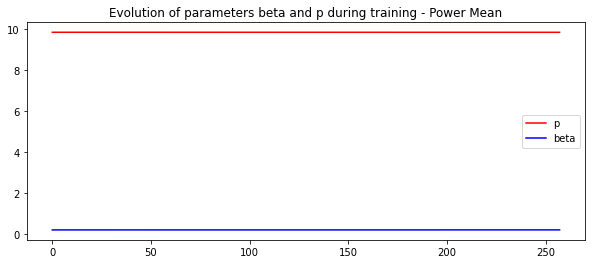

In [23]:
p_epoch    = np.array([batch["p"] for batch in epoch_values]).flatten()
beta_epoch = np.array([batch["beta"] for batch in epoch_values]).flatten() 

plt.figure(figsize=(10,4))
plt.title("Evolution of parameters beta and p during training - Power Mean")
plt.plot(p_epoch, "r-", label="p")
plt.plot(beta_epoch, "b-", label="beta")
plt.legend()
plt.show()